In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from spline_math import *
from obstacle_maneuvre import *
import pandas as pd
import sys
import os
from celluloid import Camera
sys.path.append(os.getcwd() + "/ReedsSheppPath")
sys.path.append(os.getcwd() + "/HybridAStar")


from car import check_car_collision, plot_car
from hybrid_a_star import *
from hybrid_a_star import *
from rs_elements import *

    

In [5]:
qwer = [[]]*5
qwer[0] = [4,1]
qwer[2] = [3]

qwer_new = [[]]*5
qwer_new[0] = [4,1]
qwer_new[2] = [3]

qwer_new == qwer

True

In [10]:
a = np.array([[2,3], [3,4]])
b = []
if( == b):
    print('lk')
    

/tmp/ipykernel_8619/2609830048.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if(a.all() == b):


In [15]:
a = set()
a = a.union([1,2,3])
a = a.union([1,2,5])
 in a

False

In [59]:
MIN_R = 1.0

def make_obstacle_tree(obstacles_full, visible_radius, start):
    ox, oy = [], []
    for obstcl in obstacles_full:
        ox.append(obstcl[0])
        oy.append(obstcl[1])
    tox, toy = ox[:], oy[:]
    obstacle_kd_tree = cKDTree(np.vstack((tox, toy)).T)
    indexes = obstacle_kd_tree.query_ball_point(start[:2],visible_radius)
    obstacles = [obstacles_full[ind] for ind in indexes]
    ox, oy = [], []
    for obstcl in obstacles:
        ox.append(obstcl[0])
        oy.append(obstcl[1])
    tox, toy = ox[:], oy[:]
    obstacle_kd_tree = cKDTree(np.vstack((tox, toy)).T)
    return obstacles, obstacle_kd_tree


class Robot:
    def __init__(self, id_, start, goal, border_size, obstacles, visible_r):
        self.id = id_
        self.path = None
        self.cur_pose = start
        self.path_ind = 0
        self.goal = goal
        self.replan_count = 0
        self.border_size = border_size
        self.visible_r = visible_r
        self.is_moving = True
        self.update_obstacle_configuration(obstacles)
        self.speed = 2
    def update_obstacle_configuration(self, obstacles):
        _, visible_obstacle_tree = make_obstacle_tree(obstacles, self.visible_r, self.cur_pose)
        self.visible_obstacle_tree = visible_obstacle_tree
        self.border = [[self.cur_pose[0] - self.border_size, self.cur_pose[0] + self.border_size], 
                       [self.cur_pose[1] - self.border_size, self.cur_pose[1] + self.border_size]]   

    def move(self, obstacles):
        if((self.path_ind >= len(self.path.x_list)-1-self.speed)and(self.is_moving)):
            print(f"Robot{self.id} finished way")
            self.is_moving = False
        if(self.is_moving):
            self.path_ind+=self.speed
            self.cur_pose = [self.path.x_list[self.path_ind], self.path.y_list[self.path_ind], self.path.yaw_list[self.path_ind]]
            self.update_obstacle_configuration(obstacles)
            if(check_car_collision(self.path.x_list[self.path_ind:], 
                                   self.path.y_list[self.path_ind:], 
                                   self.path.yaw_list[self.path_ind:], 
                                   self.visible_obstacle_tree) == False):
                print(f"Robot{self.id} replan way")  
                self.replan()
        return not self.is_moving
                    
    def replan(self):
        self.path_ind = 0
        self.replan_count+=1
        self.path = hybrid_a_star_planning(
                    self.cur_pose, [self.goal], 
                    self.border, self.visible_obstacle_tree, 
                    MIN_R, _show_animation_ = False)
        return self.path

    def plot(self):
        plot_car(self.cur_pose[0], self.cur_pose[1], self.cur_pose[2])
        plt.plot(self.path.x_list[self.path_ind:], self.path.y_list[self.path_ind:], c = 'r')
        
class Robot_envieroment():
    def __init__(self, robot_list, obstacles_conf, obstcl_r):
        self.robot_list = robot_list
        self.obstacl_r = obstcl_r
        self.obstacles_conf = obstacles_conf
        for robot in robot_list:
            robot.replan()
            
    def show(self, ax):
        draw_obstacles(ax, self.obstacles_conf, self.obstacl_r)
        for robot in self.robot_list:
            robot.plot()
            
    def move(self):
        mooving_list = np.array([False]*len(self.robot_list))
        for i, robot in enumerate(self.robot_list):
            mooving_list[i] = robot.move(self.obstacles_conf)
        return np.all(mooving_list==False)

In [51]:
def draw_obstacles(ax, obstcl_arr, min_obstcle_avoid_radius, color = 'k'):
    for obstc in obstcl_arr:
        ax.scatter(obstc[0], obstc[1], c = 'k')
        circle1 = plt.Circle((obstc[0], obstc[1]), min_obstcle_avoid_radius, color=color, fill = False)
        ax.add_patch(circle1)
        

obstacles_full = [  [0.01, 0.5],
                    [3.1, -0.8],
                    [1.0,-1.9],
                    [1.0, -2.6],
                    [-1.0, -5.0],
                    [-2,-4],
                    [0, -4.7],
                    [2,-4],
                    [4,-2],
                    [0,-0.3],
                    [-1.6,1.5],
                    [-3,2],
                    [-5,-4],
                    [1.7,-4.3],
                    [ -4, -4],
                    [-4.4,2],
                    [2.2,-1.2],
                    [1.8,-0.5]
                    ]
obstacles_full = np.array(obstacles_full)     
                                              


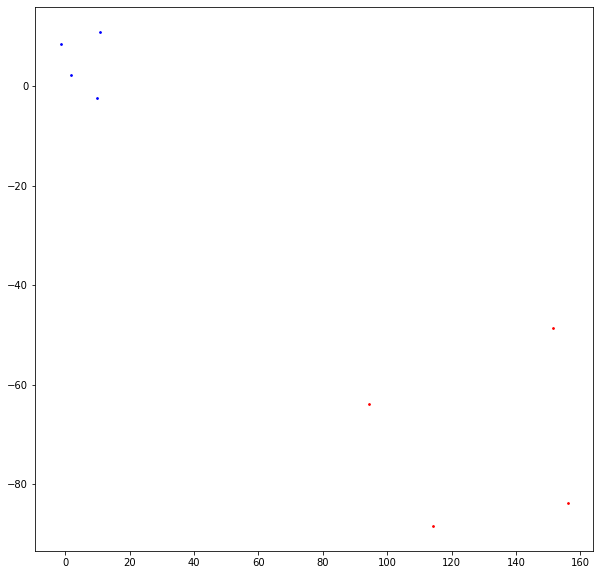

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points_with_min_distance(n, shape, min_dist):
    # compute grid shape based on number of points
    width_ratio = shape[1] / shape[0]
    num_y = np.int32(np.sqrt(n / width_ratio)) + 1
    num_x = np.int32(n / num_y) + 1

    # create regularly spaced neurons
    x = np.linspace(0., shape[1]-1, num_x, dtype=np.float32)
    y = np.linspace(0., shape[0]-1, num_y, dtype=np.float32)
    coords = np.stack(np.meshgrid(x, y), -1).reshape(-1,2)

    # compute spacing
    init_dist = np.min((x[1]-x[0], y[1]-y[0]))

    # perturb points
    max_movement = (init_dist - min_dist)/2
    noise = np.random.uniform(low=-max_movement,
                                high=max_movement,
                                size=(len(coords), 2))
    coords += noise

    return coords

def make_random_poses(x0_mean, y0_mean, width, min_dist, N):
    coords = generate_points_with_min_distance(n=N, shape=(width,width), min_dist = 4)
    start_mean = np.array([x0_mean, y0_mean])
    for elem in coords:
        elem+=start_mean
        
    angles = np.random.uniform(low=-np.pi,
                                high=np.pi,
                                size=(len(coords), 1))
    poses = np.hstack((coords, angles))
    return poses

N = 3
startx0 = 0
starty0 = 0
start_width = 10
start_min_dist = 5


goalx0 = 100
goaly0 = -100
goal_width = 40
goal_min_dist = 15



start_poses = make_random_poses(startx0, starty0, start_width, start_min_dist, N)
goal_poses = make_random_poses(goalx0, goaly0, goal_width, goal_min_dist, N)

plt.figure(figsize=(10,10))
plt.scatter(start_poses[:,0], start_poses[:,1], s=3, c = 'b')
plt.scatter(goal_poses[:,0], goal_poses[:,1], s=3, c = 'r')
plt.show()

In [159]:
startx0 = 100
starty0 = -50
start_mean = np.array([startx0, starty0])
for elem in coords:
    elem+=start_mean
coords

array([[100.07645 , -49.90599 ],
       [108.931915, -50.162674],
       [ 99.81716 , -45.394436],
       [108.86844 , -45.640438],
       [100.015816, -40.783478],
       [109.15346 , -40.95774 ]], dtype=float32)

In [164]:

start_poses

array([[100.07644653, -49.9059906 ,   1.6184971 ],
       [108.93191528, -50.16267395,  -1.60713505],
       [ 99.81716156, -45.39443588,   2.65690379],
       [108.86843872, -45.64043808,  -1.79171515],
       [100.01581573, -40.78347778,  -1.7529995 ],
       [109.15345764, -40.95774078,   0.48046724]])

In [106]:
tree.toarray()

array([[    0.        , 13845.43542734],
       [13845.43542734,     0.        ]])

In [58]:
obstacles_visible.shape

(18, 2)

In [61]:
obstacle_kd_tree = cKDTree(obstacles_full)
indexes = obstacle_kd_tree.query_ball_point(start[:2],18)
obstacles_visible = np.array([obstacles_full[ind] for ind in indexes])
obstacle_kd_tree_visible = cKDTree(obstacles_visible)

In [26]:
start = [0.0, -15, np.deg2rad(70.0)]
ox, oy = [], []
for obstcl in obstacles_full:
    ox.append(obstcl[0])
    oy.append(obstcl[1])
tox, toy = ox[:], oy[:]
# obstacle_kd_tree = cKDTree(np.vstack((tox, toy)).T)
# indexes = obstacle_kd_tree.query_ball_point(start[:2],1900)
# obstacles = [obstacles_full[ind] for ind in indexes]
# ox, oy = [], []
# for obstcl in obstacles:
#     ox.append(obstcl[0])
#     oy.append(obstcl[1])
# tox, toy = ox[:], oy[:]
np.vstack((tox, toy))

array([[ 0.01,  3.1 ,  1.  ,  1.  , -1.  , -2.  ,  0.  ,  2.  ,  4.  ,
         0.  , -1.6 , -3.  , -5.  ,  1.7 , -4.  , -4.4 ,  2.2 ,  1.8 ],
       [ 0.5 , -0.8 , -1.9 , -2.6 , -5.  , -4.  , -4.7 , -4.  , -2.  ,
        -0.3 ,  1.5 ,  2.  , -4.  , -4.3 , -4.  ,  2.  , -1.2 , -0.5 ]])

min x -250 min y -288 min yaw -36
max x 250 max y 212 max yaw 36
x_w 500 y_w 500 yaw_w 72
n_iter = 1120, len close = 1088, len open = 1229
min x -275 min y -275 min yaw -36
max x 225 max y 225 max yaw 36
x_w 500 y_w 500 yaw_w 72
n_iter = 151, len close = 151, len open = 256
min x -260 min y -272 min yaw -36
max x 240 max y 228 max yaw 36
x_w 500 y_w 500 yaw_w 72
n_iter = 194, len close = 186, len open = 236


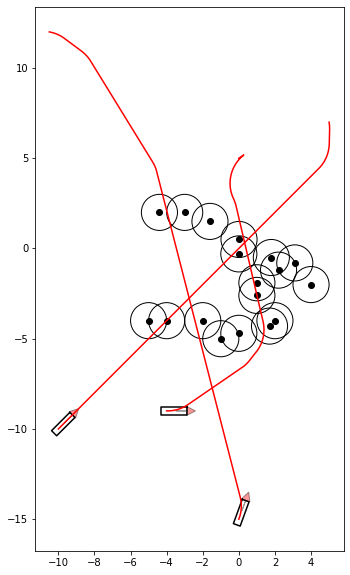

In [60]:
border_size = 100


goal1 = [-10.5, 12, np.deg2rad(170.0)]
start1 = [0.0, -15, np.deg2rad(70.0)]
robot1 = Robot(0, start1, goal1, border_size, obstacles_full, 1)


start2 = [-10, -10, np.deg2rad(45.0)]
goal2 =  [5, 7, np.deg2rad(100.0)]
robot2 = Robot(1, start2, goal2, border_size, obstacles_full, 7)

start3 = [-4, -9, np.deg2rad(0.0)]
goal3 =  [0, 5, np.deg2rad(29.0)]
robot3 = Robot(2, start3, goal3, border_size, obstacles_full, 7)


robot_list = [robot1, robot2, robot3]
robor_env = Robot_envieroment(robot_list, obstacles_full, MIN_R)

fig = plt.figure(figsize = (10,10))
ax = plt.axes()
robor_env.show(ax)
#plot_car(goal1[0], goal1[1], goal1[2])


plt.gca().set_aspect('equal', adjustable='box')

start
min x -250 min y -288 min yaw -36
max x 250 max y 212 max yaw 36
x_w 500 y_w 500 yaw_w 72
n_iter = 1841, len close = 1735, len open = 1180
1


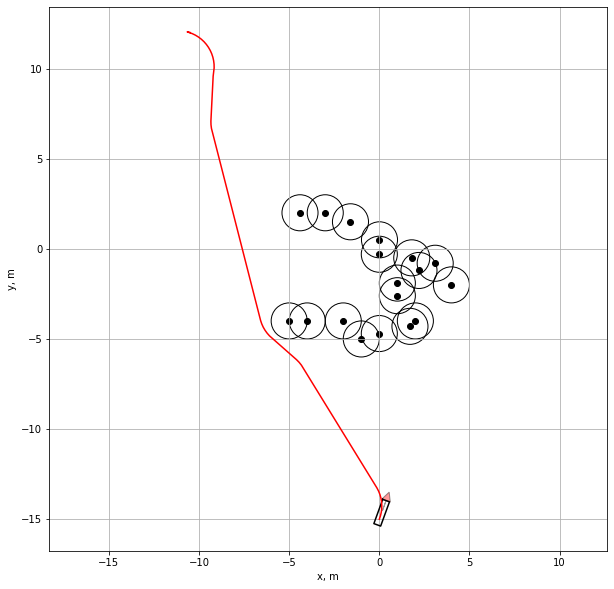

2


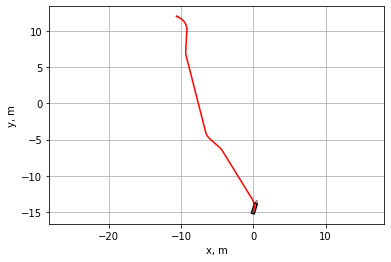

3


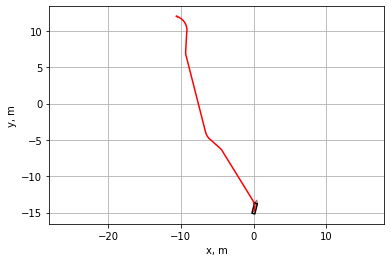

4


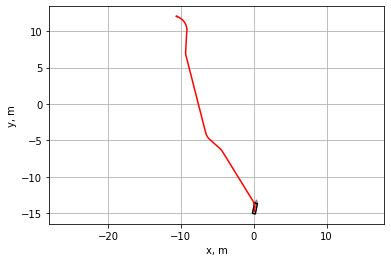

5


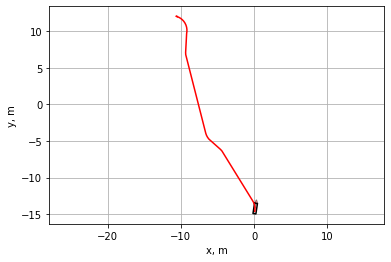

6


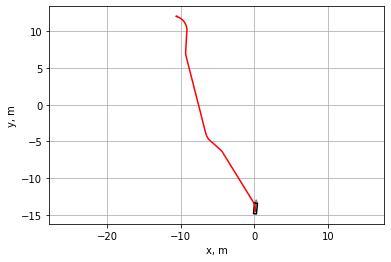

7


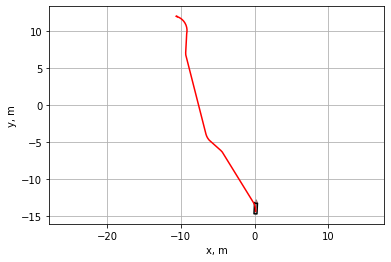

8


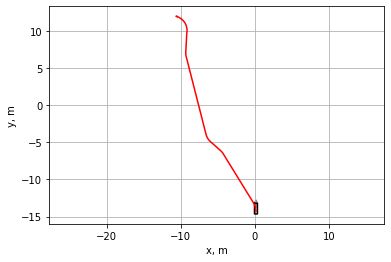

9


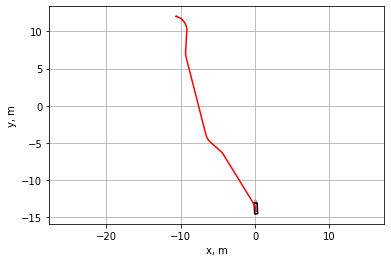

10


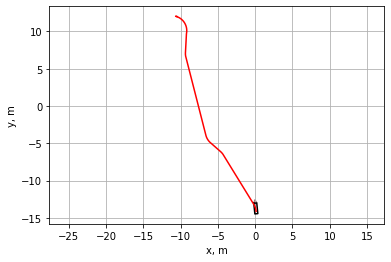

11


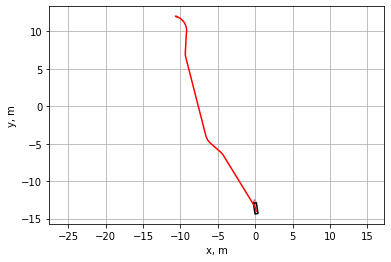

12


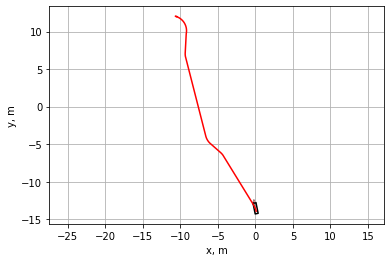

13


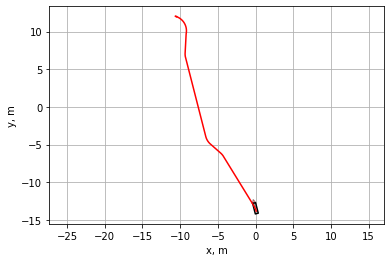

14


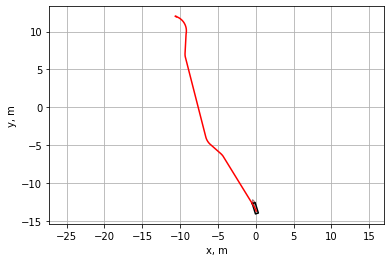

15


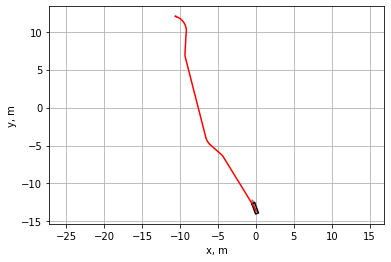

16


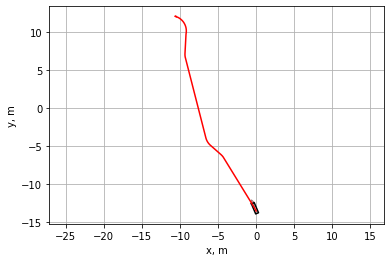

17


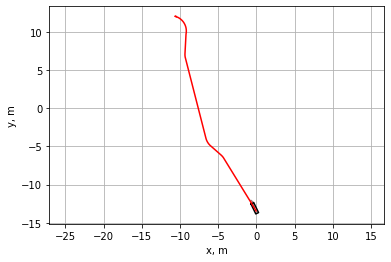

18


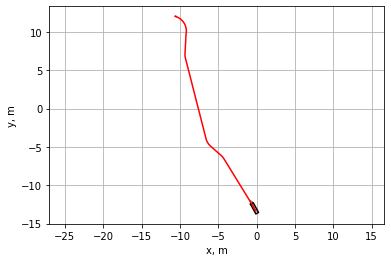

19


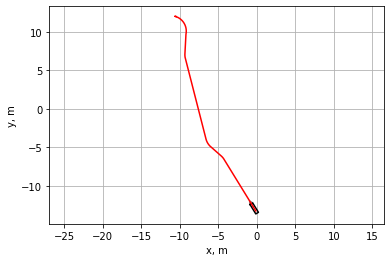

20


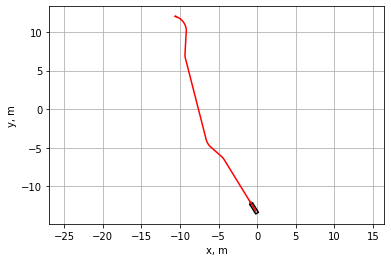

21


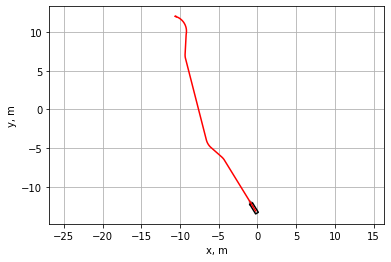

22


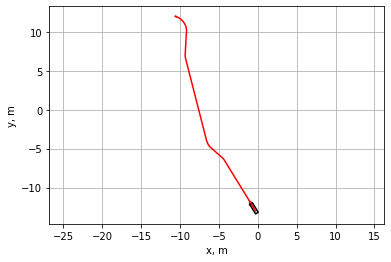

23


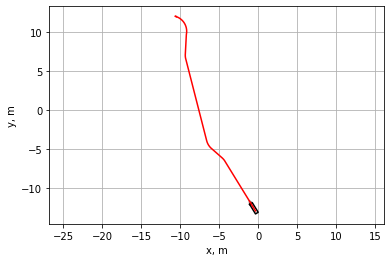

24


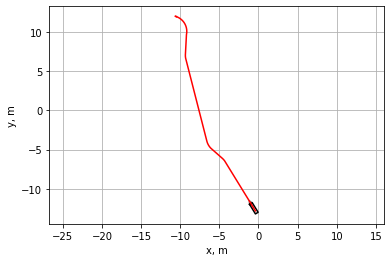

25


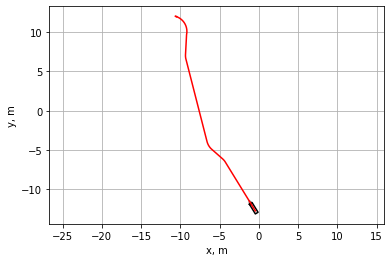

26


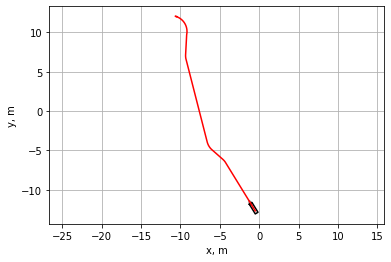

27


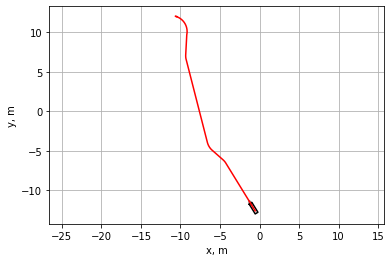

28


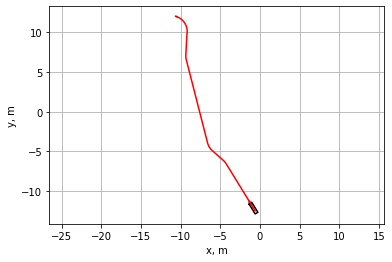

29


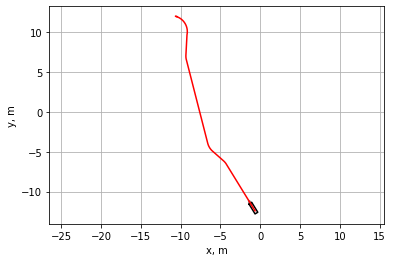

30


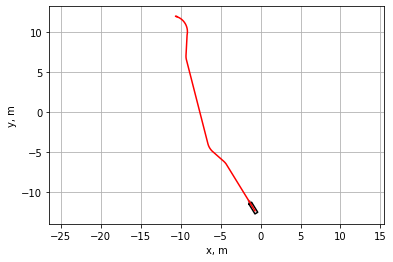

31


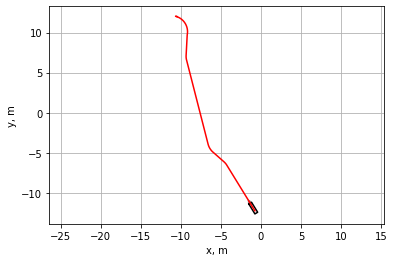

32


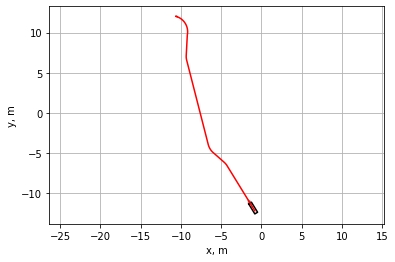

33


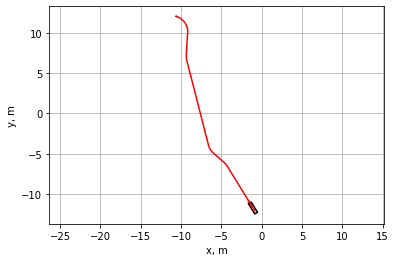

34


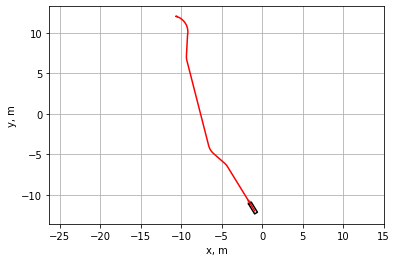

35


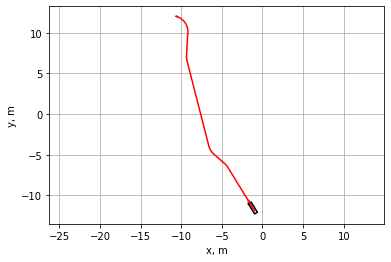

36


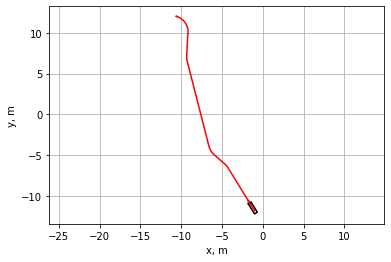

37


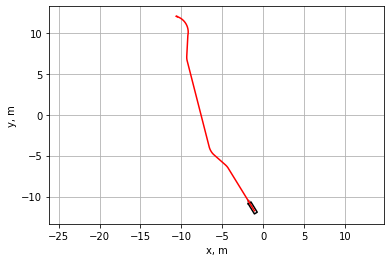

38


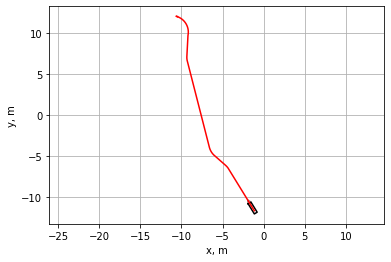

39


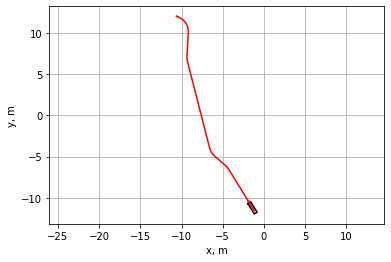

40


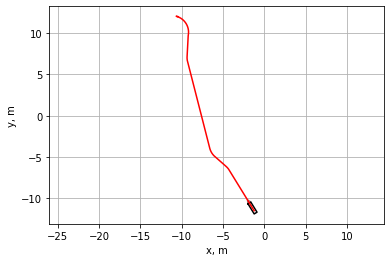

41


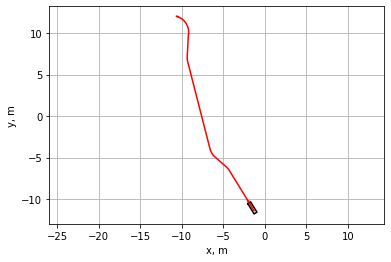

42


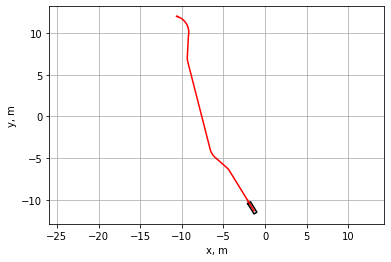

43


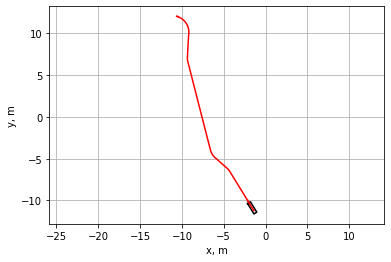

44


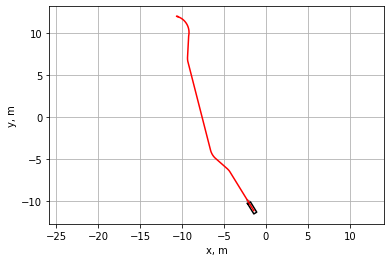

45


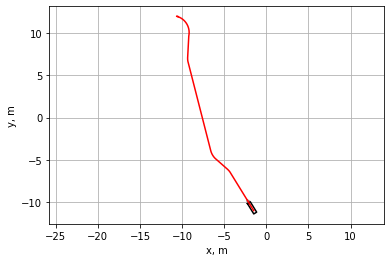

46


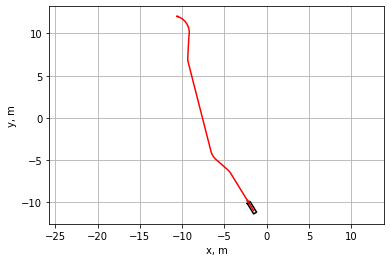

47


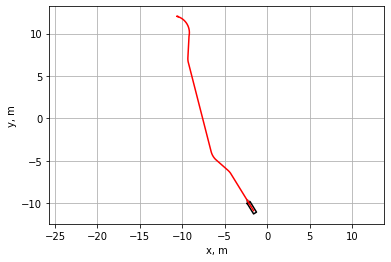

48


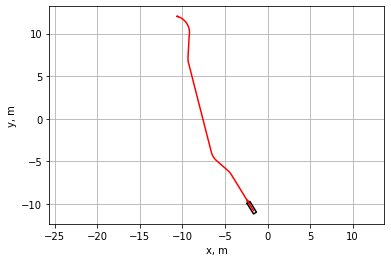

49


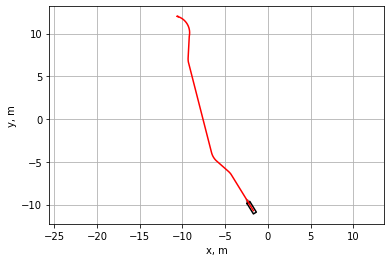

50


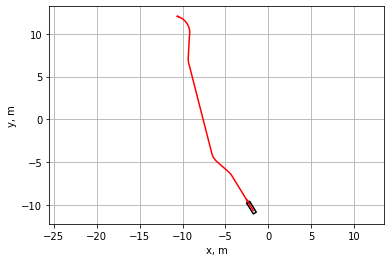

51


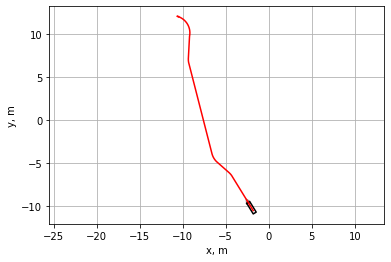

52


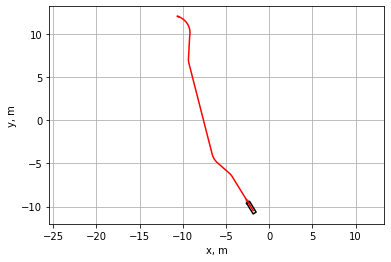

53


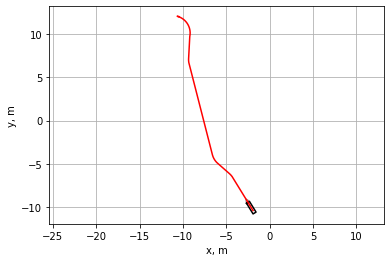

54


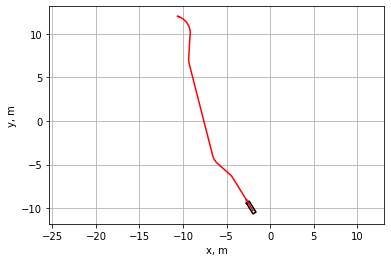

55


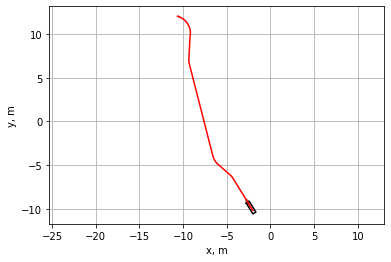

56


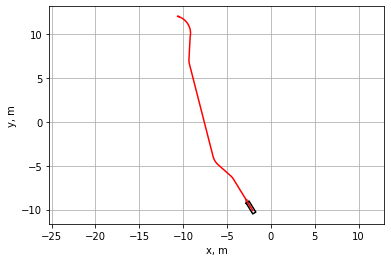

57


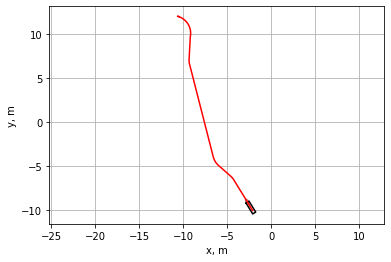

58


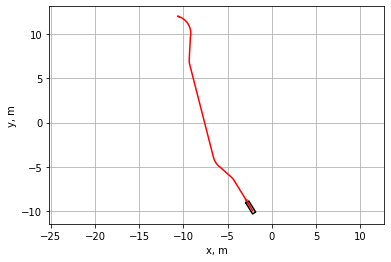

59


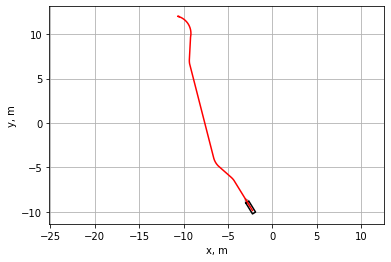

60


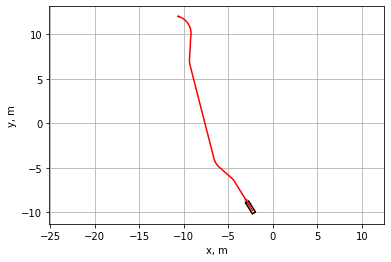

61


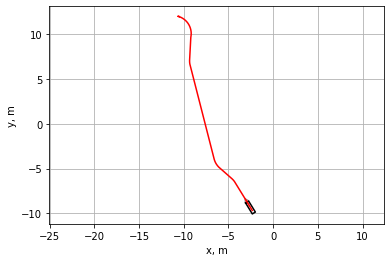

62


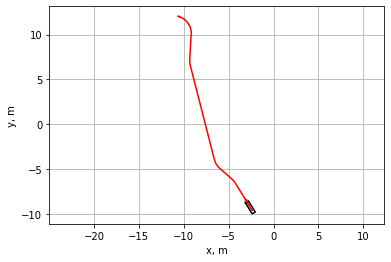

63


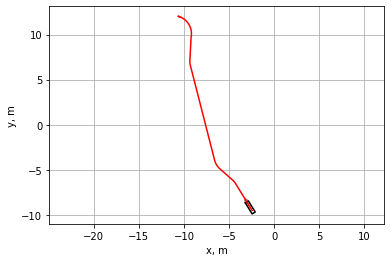

64


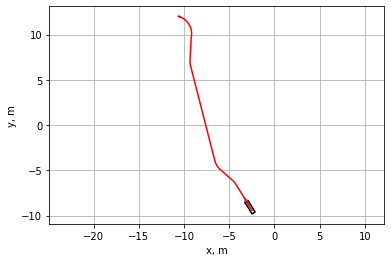

65


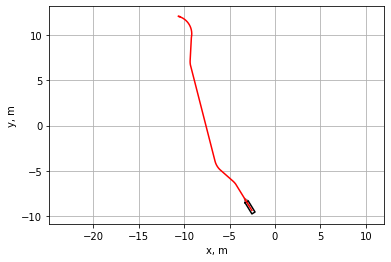

66


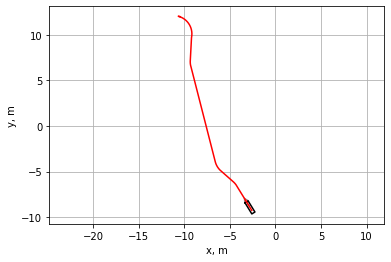

67


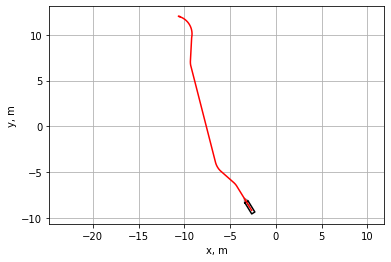

68


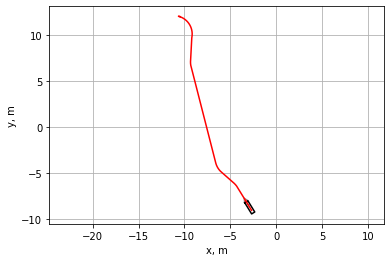

69


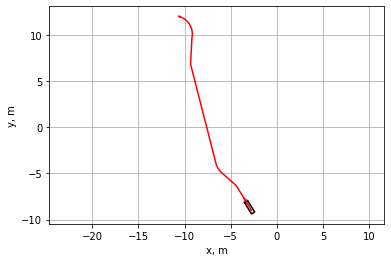

70


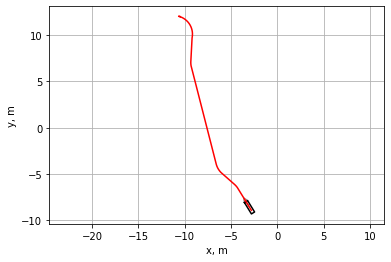

71


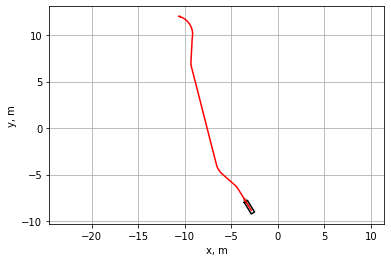

72


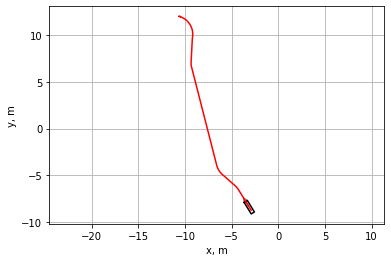

73


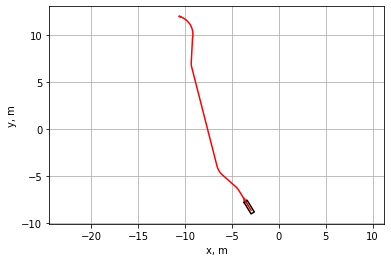

74


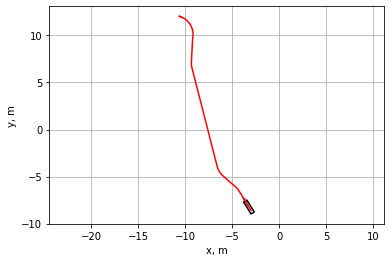

75


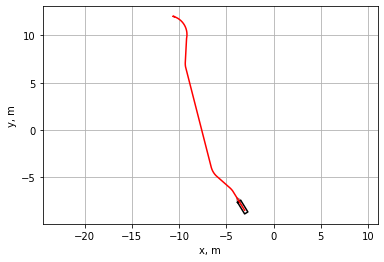

76


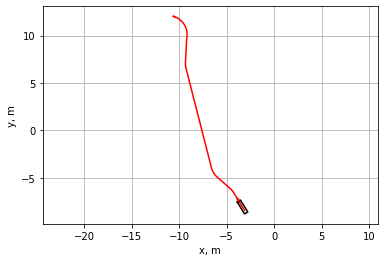

77


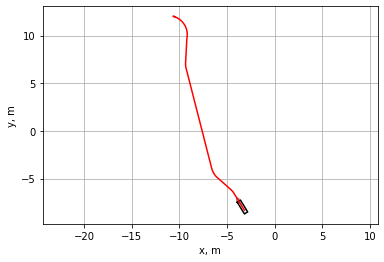

78


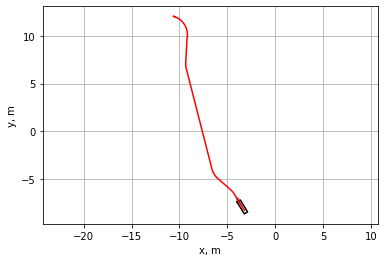

79


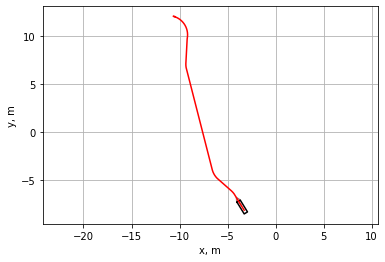

80


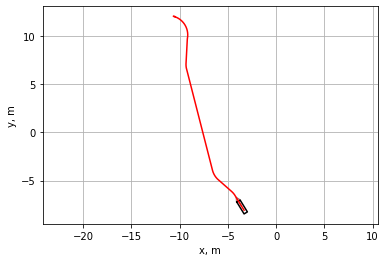

81


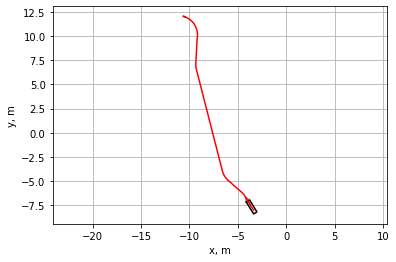

82


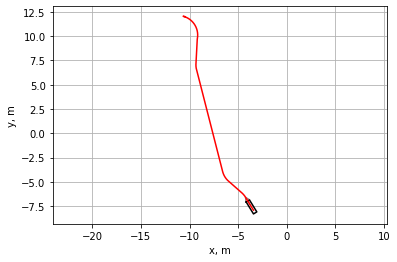

83


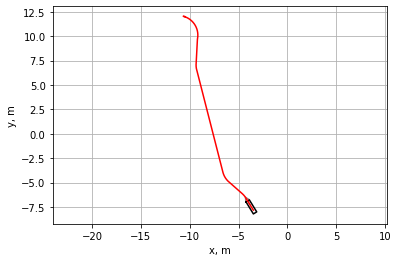

84


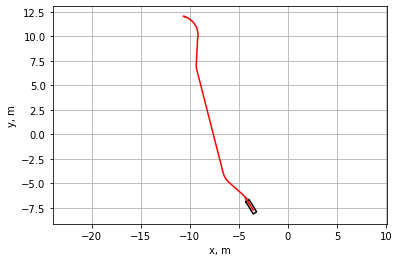

85


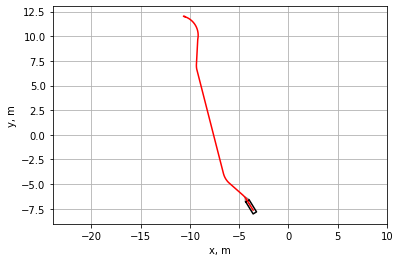

86


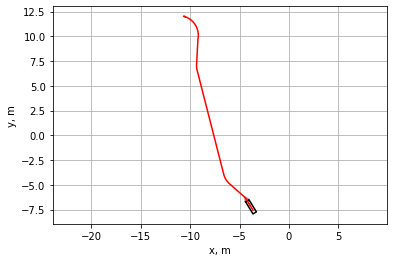

87


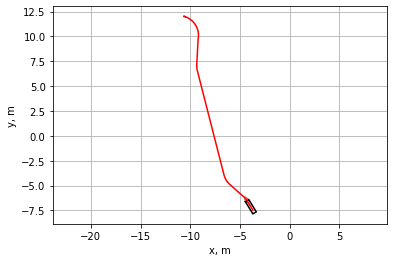

88


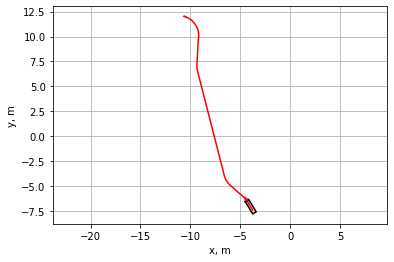

89


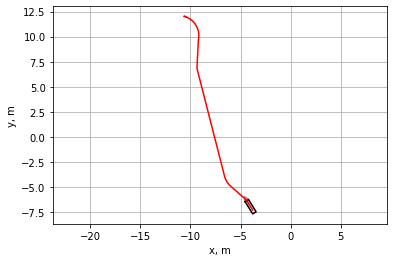

90


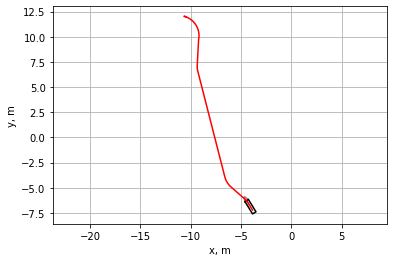

91


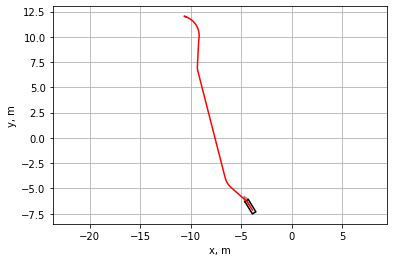

92


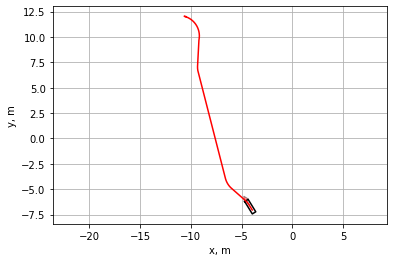

93


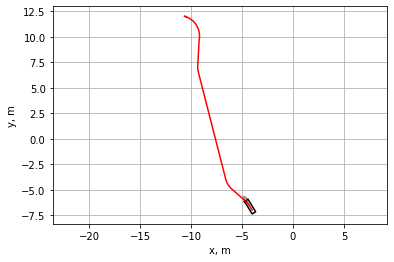

94


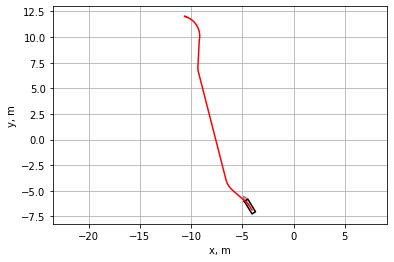

95


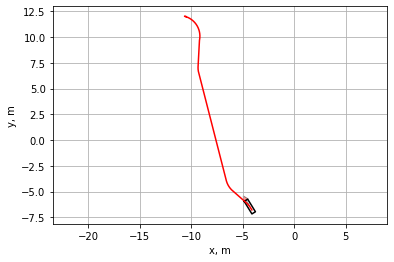

96


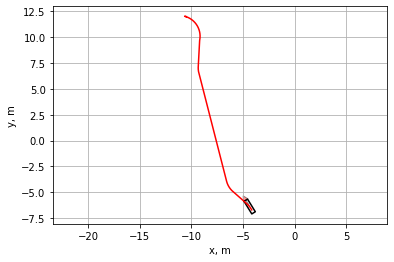

97


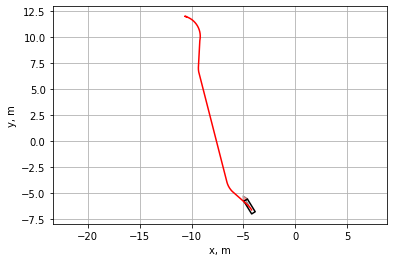

98


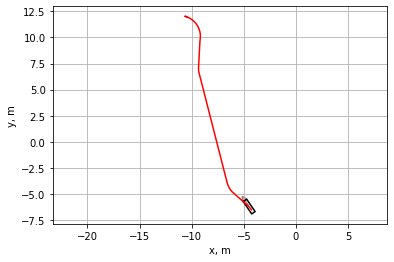

99


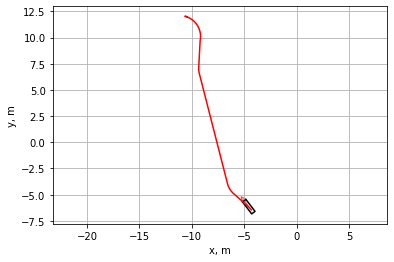

100


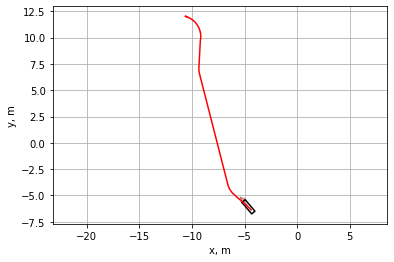

101


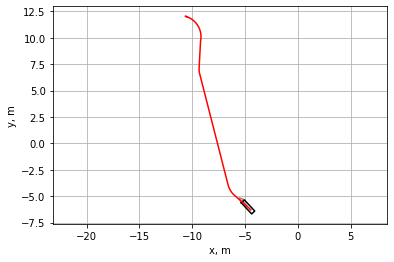

102


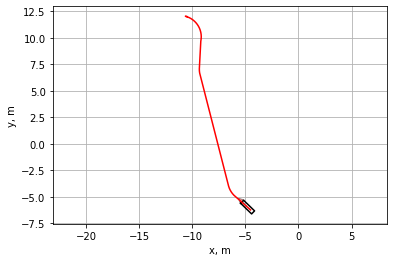

103


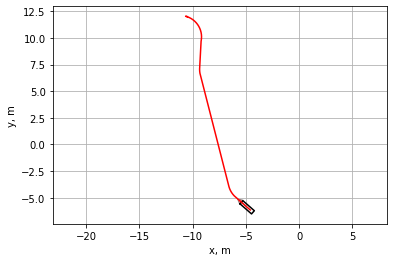

104


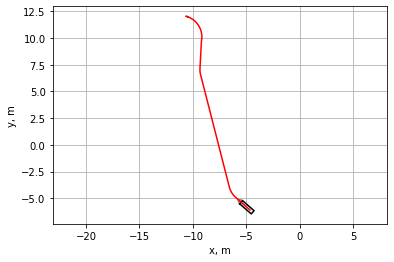

105


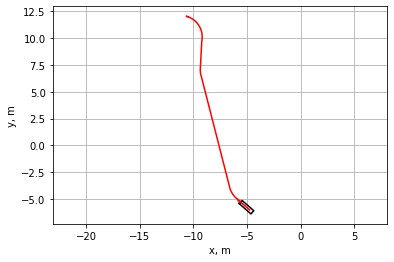

106


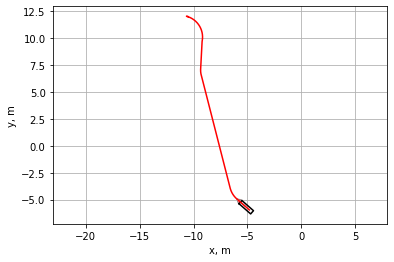

107


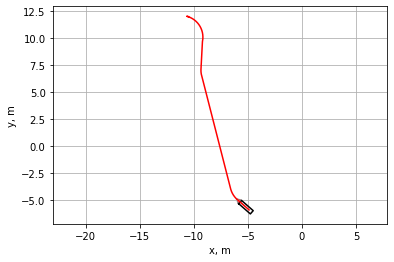

108


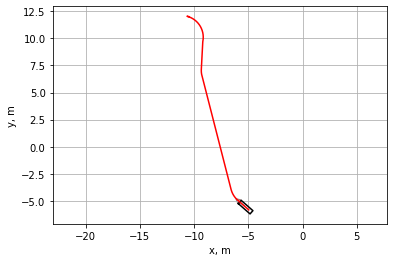

109


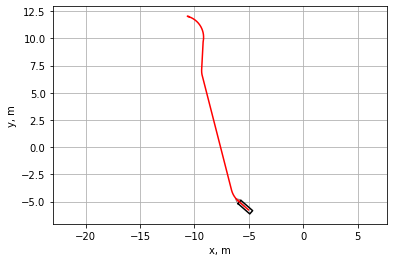

110


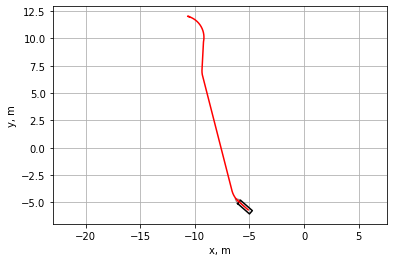

111


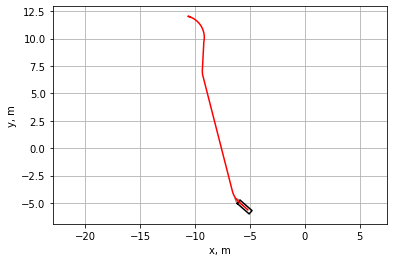

112


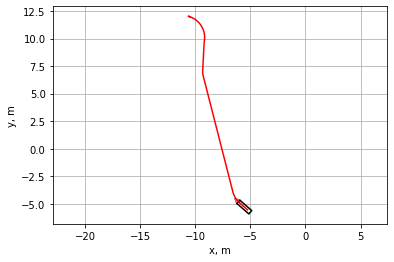

113


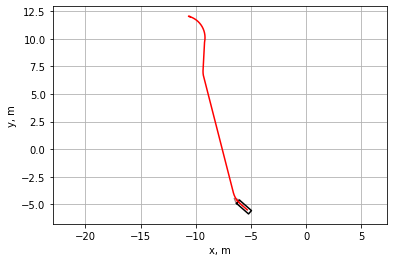

114


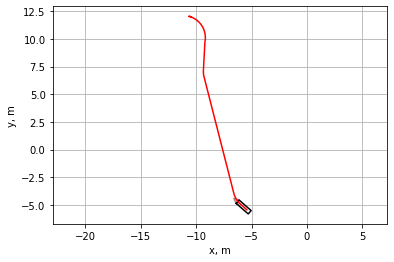

115


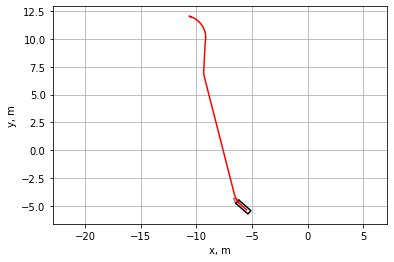

116


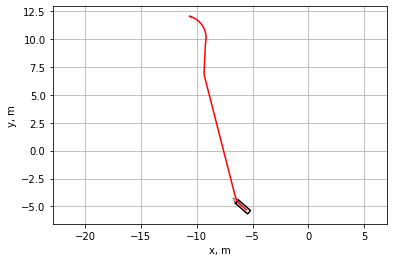

117


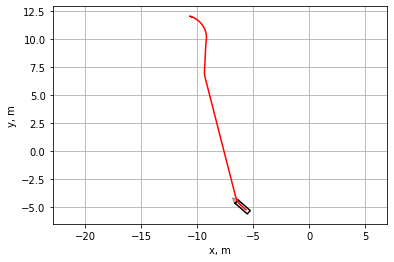

118


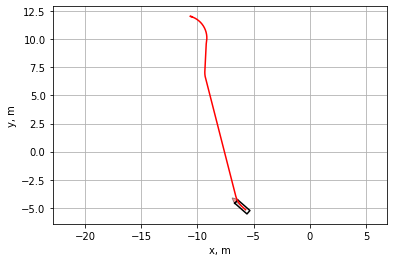

119


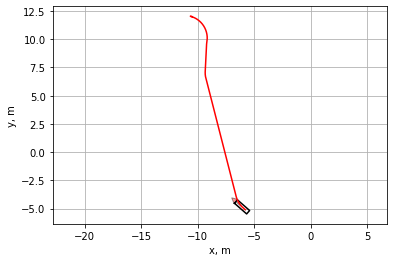

120


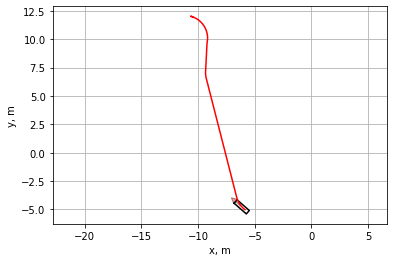

121


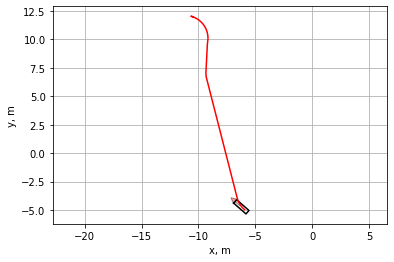

122


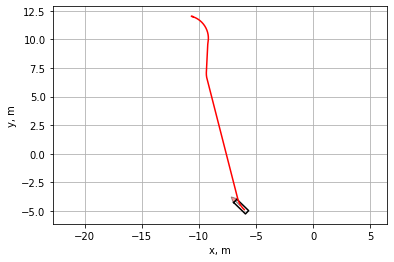

123


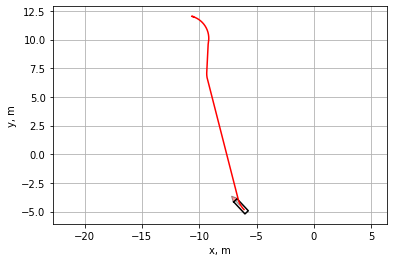

124


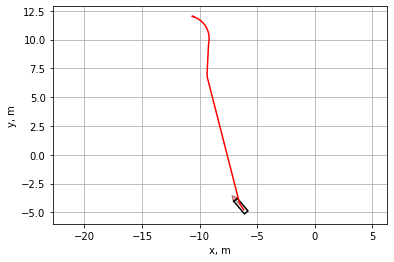

125


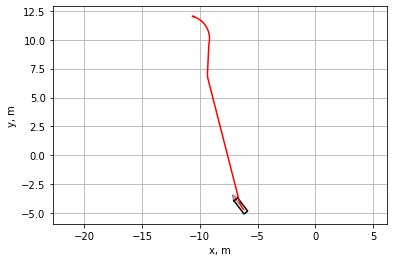

126


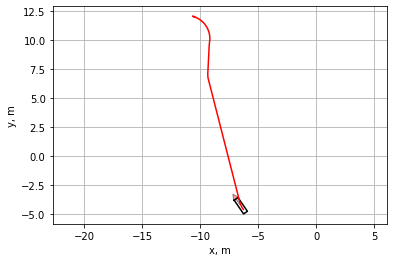

127


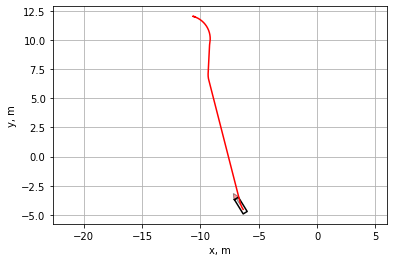

128


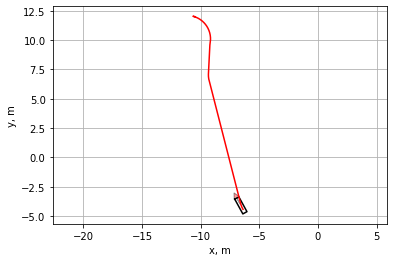

129


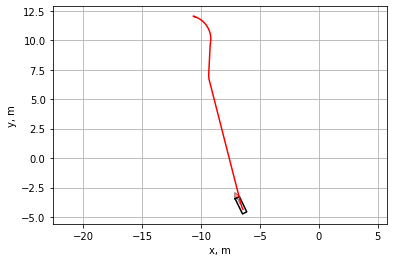

130


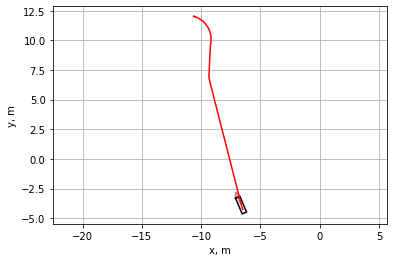

131


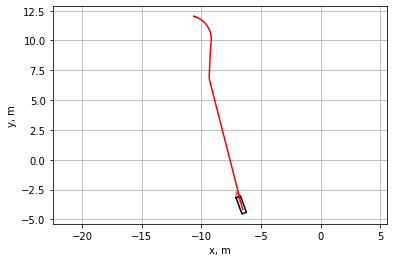

132


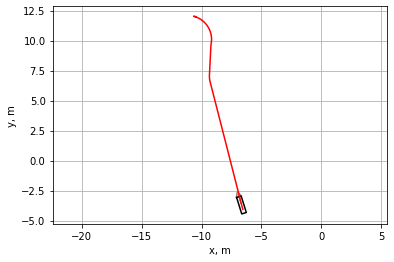

133


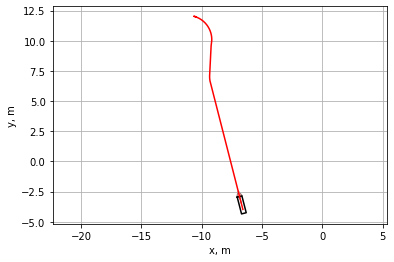

134


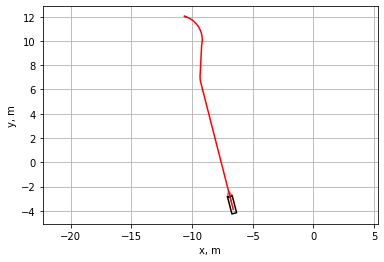

135


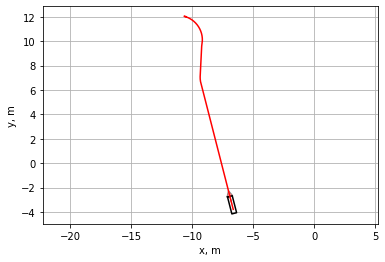

136


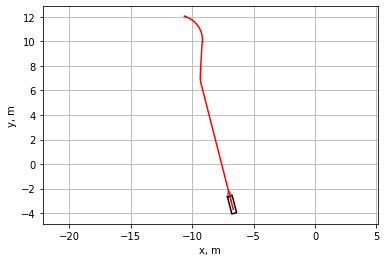

137


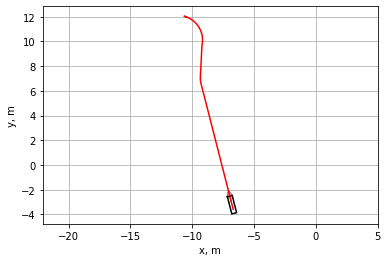

138


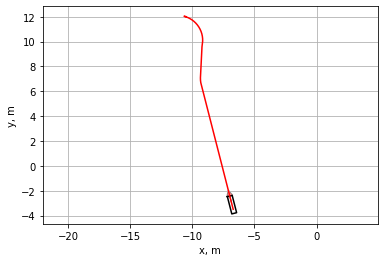

139


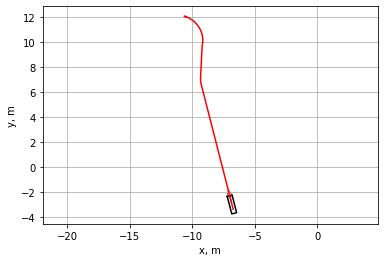

140


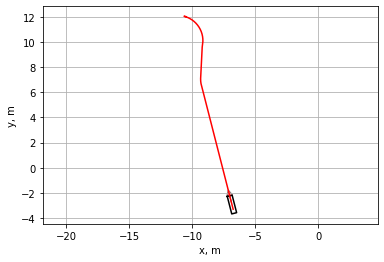

141


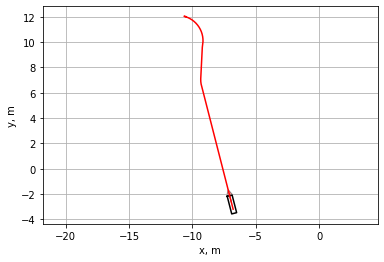

142


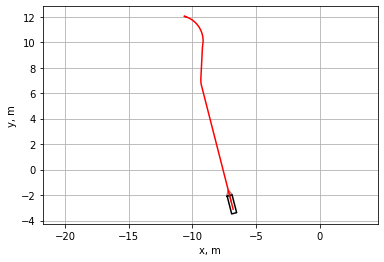

143


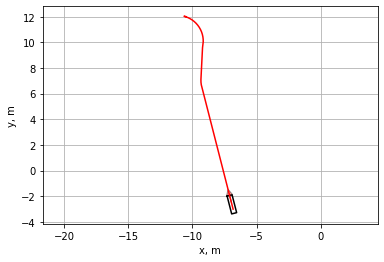

144


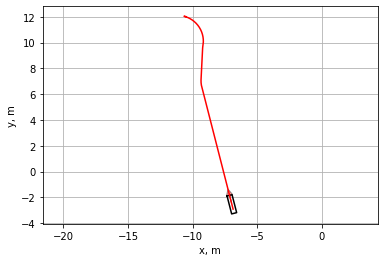

145


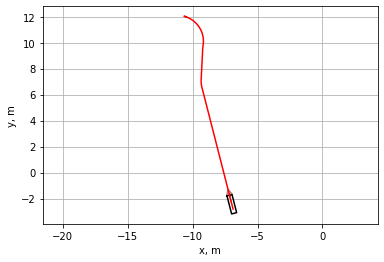

146


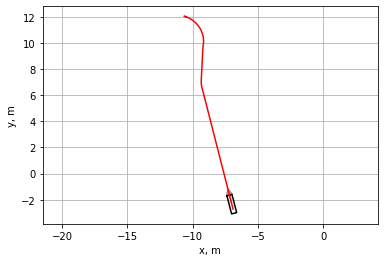

147


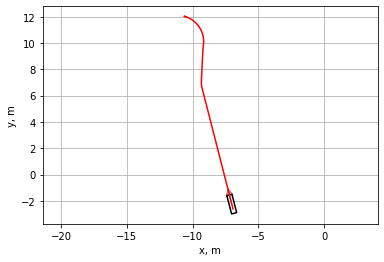

148


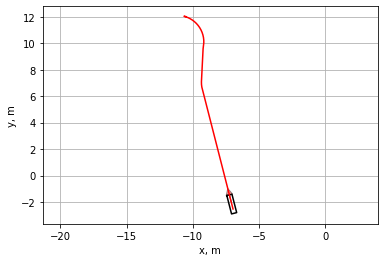

149


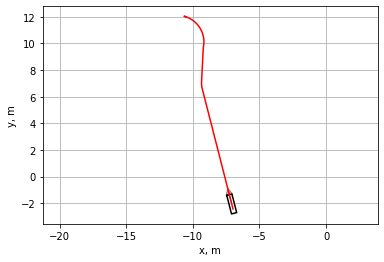

150


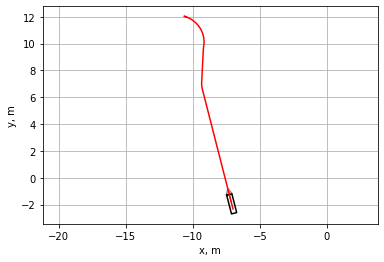

151


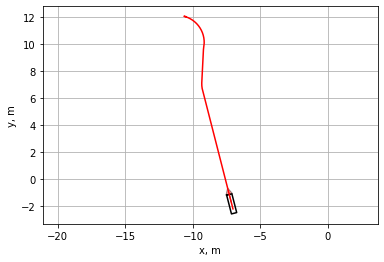

152


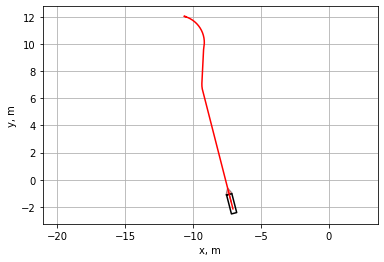

153


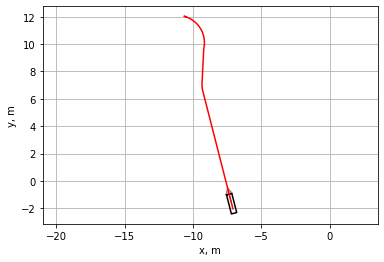

154


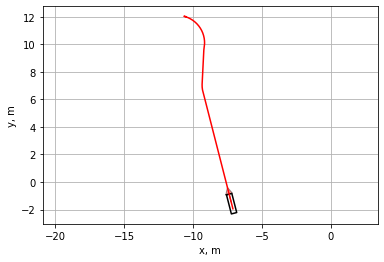

155


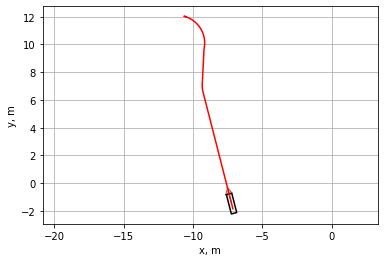

156


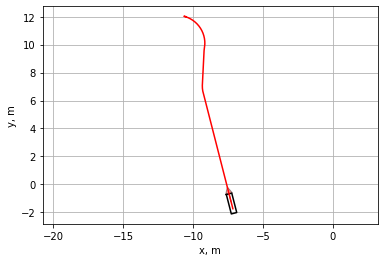

157


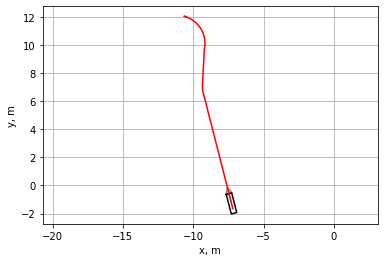

158


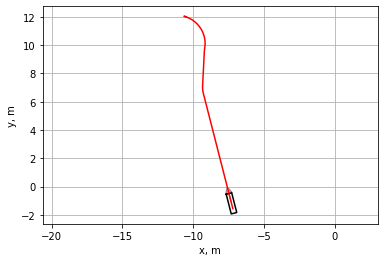

159


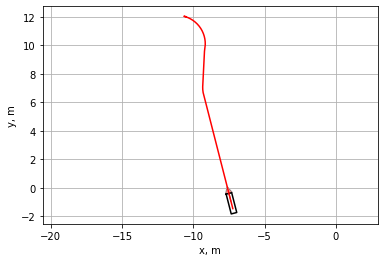

160


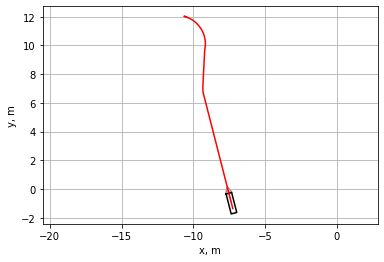

161


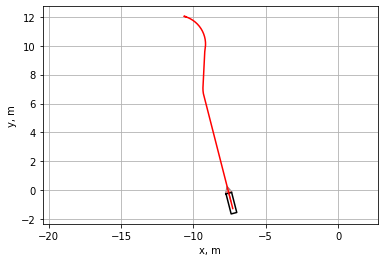

162


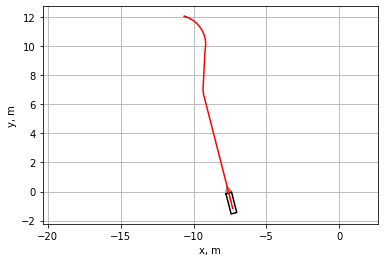

163


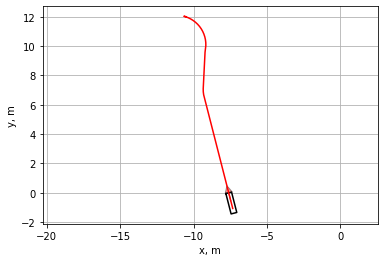

164


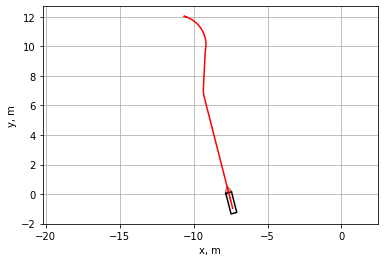

165


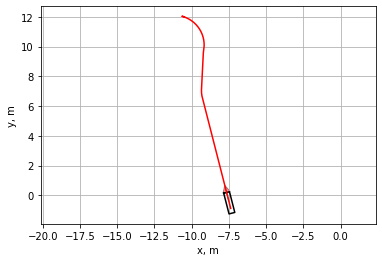

166


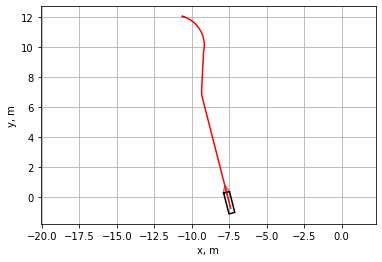

167


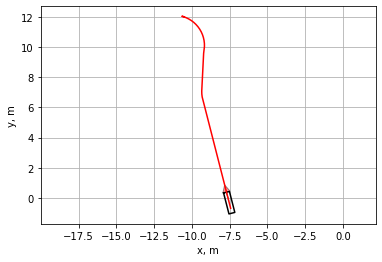

168


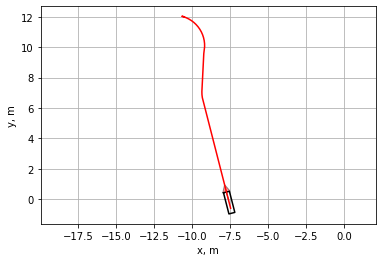

169


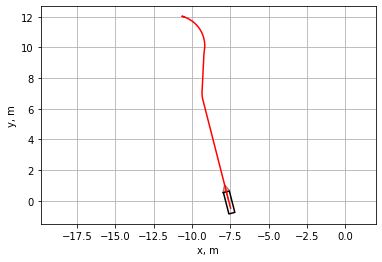

170


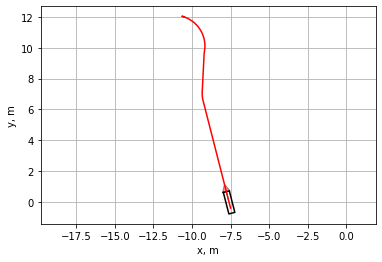

171


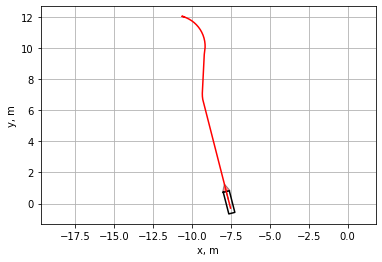

172


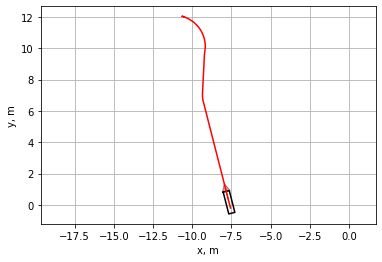

173


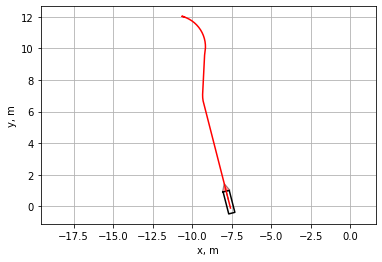

174


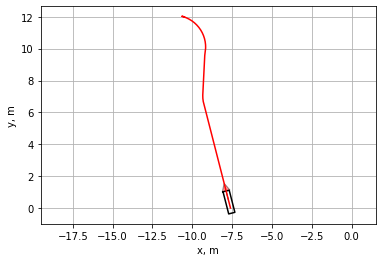

175


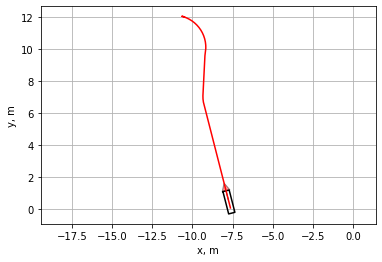

176


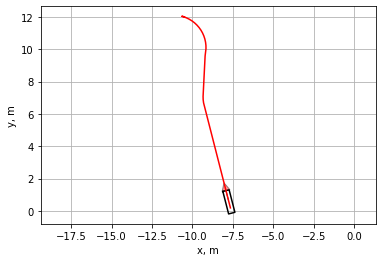

177


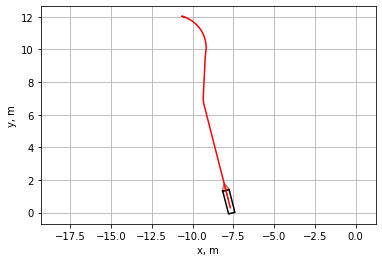

178


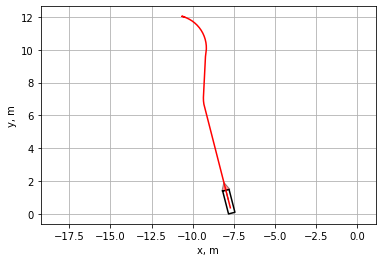

179


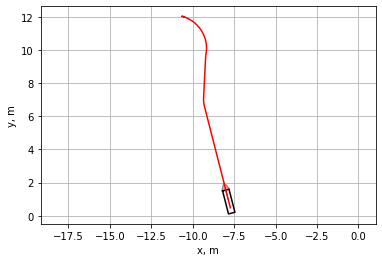

180


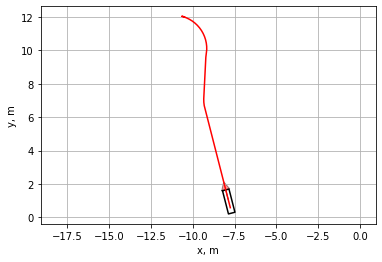

181


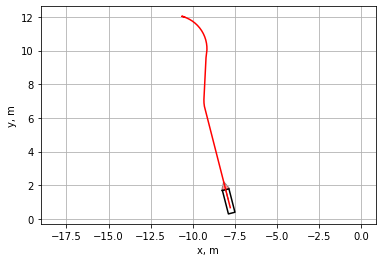

182


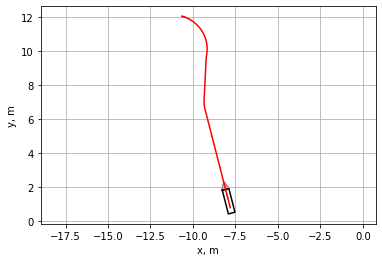

183


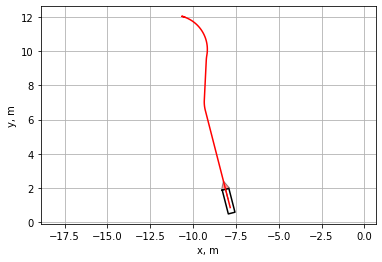

184


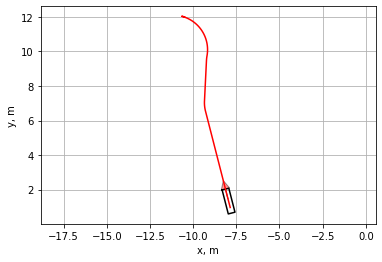

185


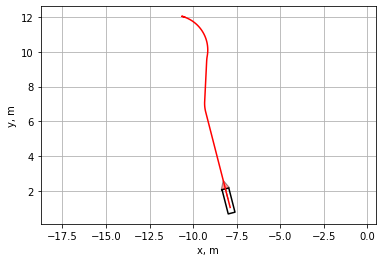

186


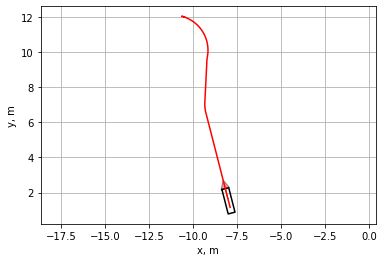

187


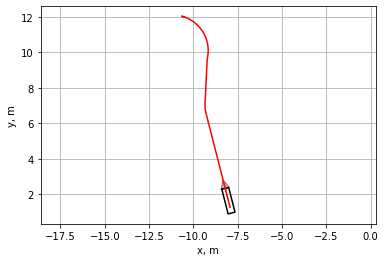

188


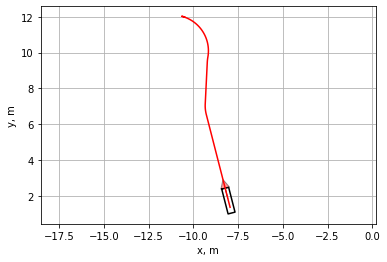

189


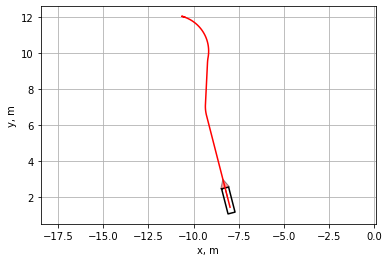

190


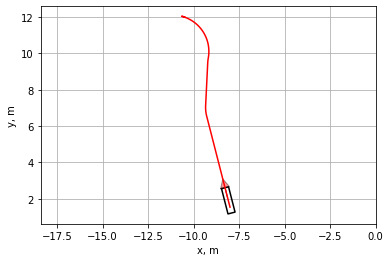

191


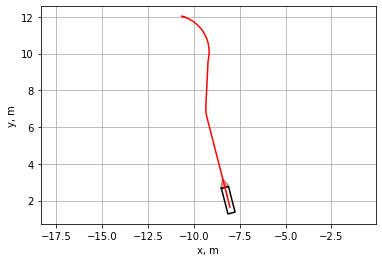

192


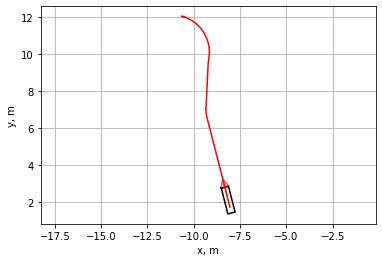

193


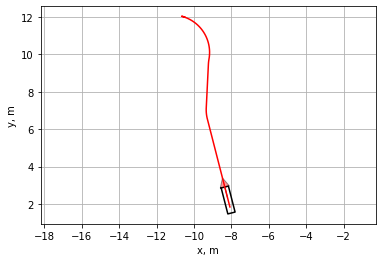

194


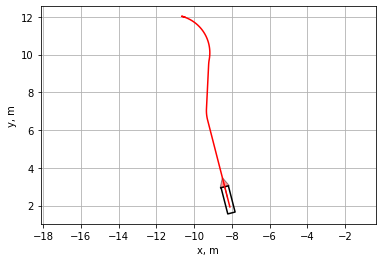

195


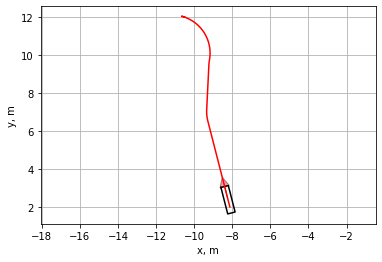

196


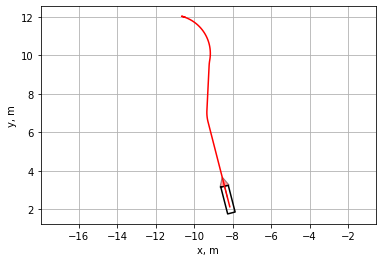

197


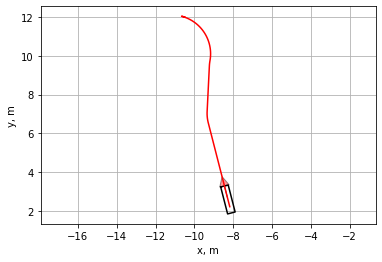

198


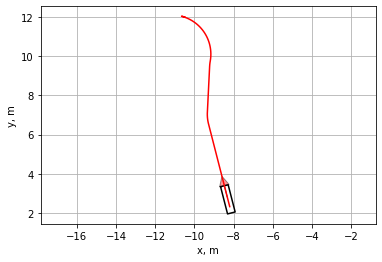

199


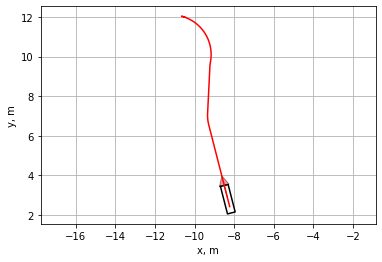

200


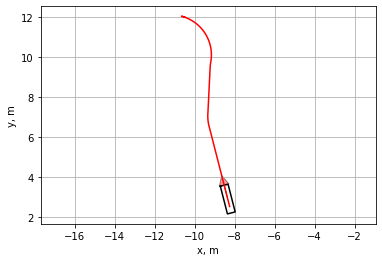

201


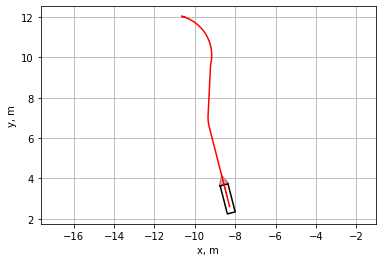

202


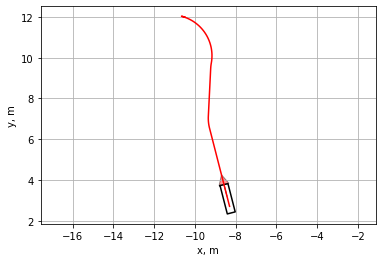

203


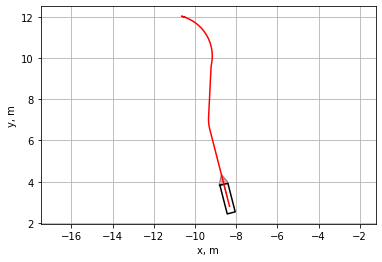

204


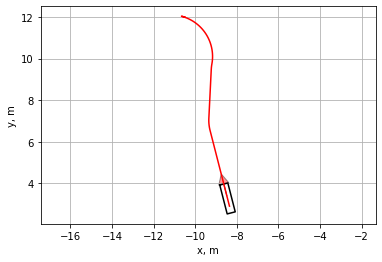

205


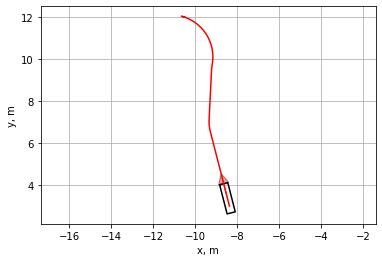

206


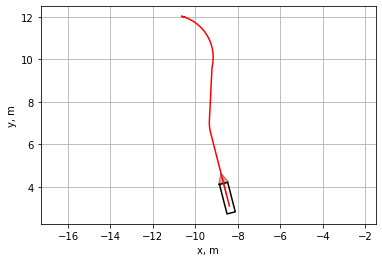

207


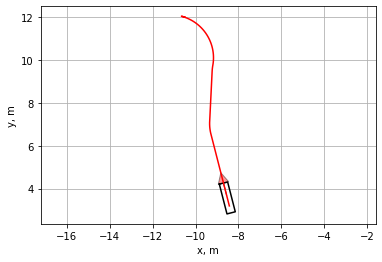

208


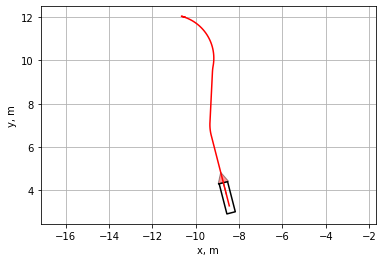

209


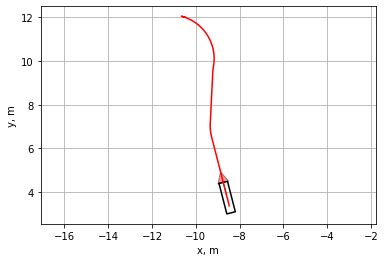

210


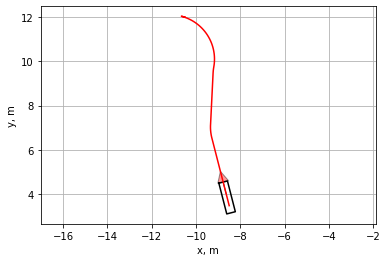

211


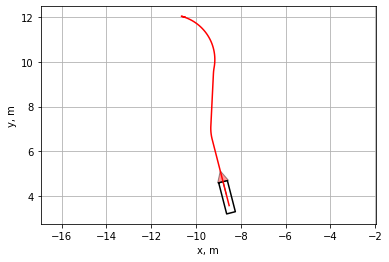

212


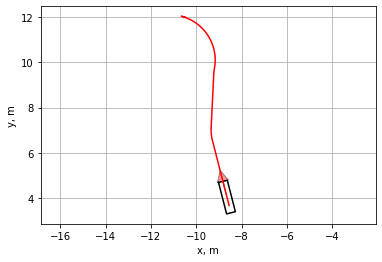

213


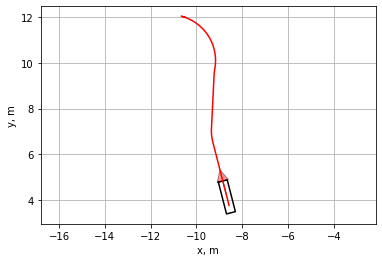

214


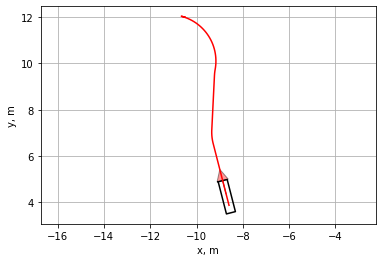

215


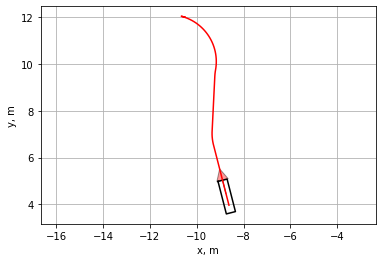

216


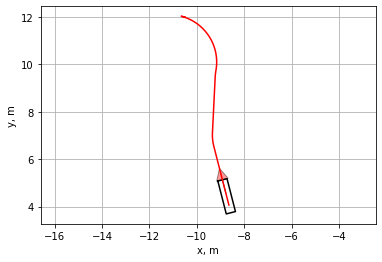

217


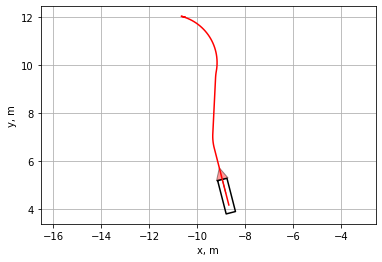

218


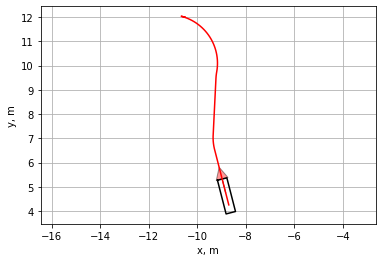

219


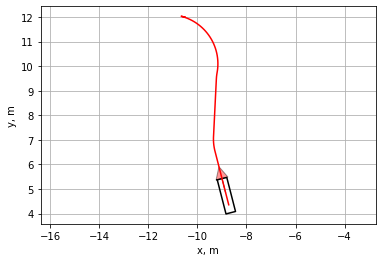

220


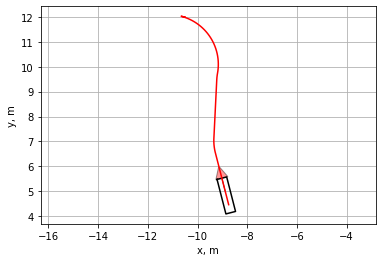

221


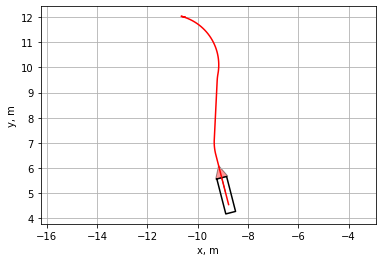

222


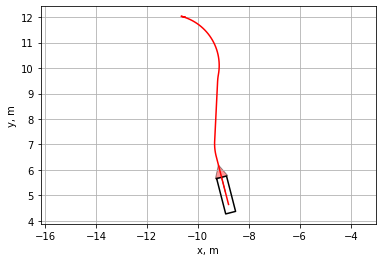

223


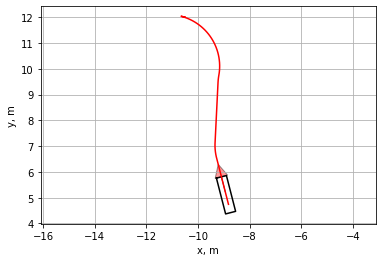

224


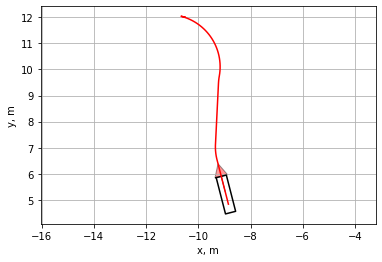

225


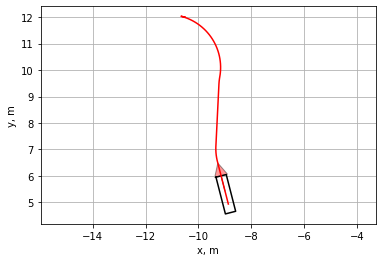

226


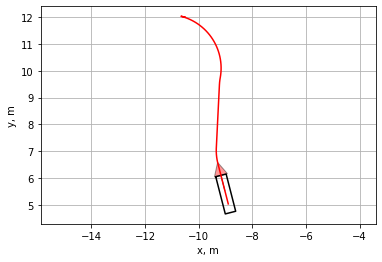

227


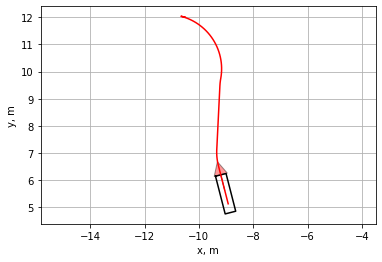

228


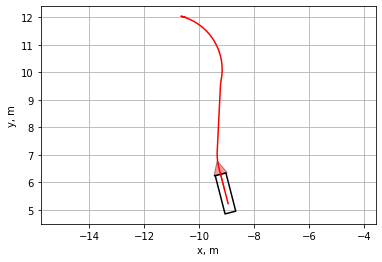

229


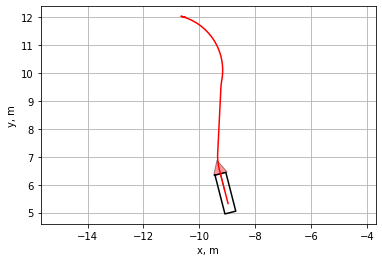

230


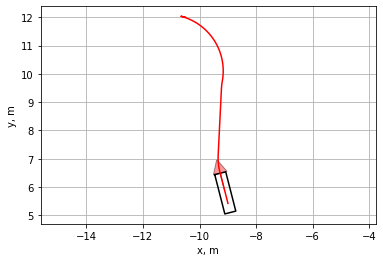

231


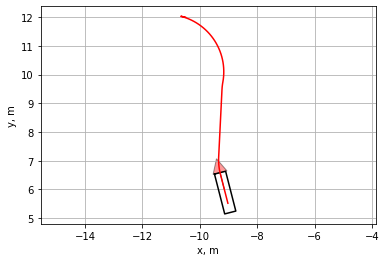

232


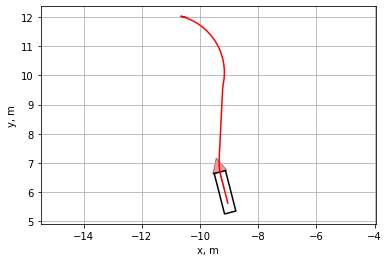

233


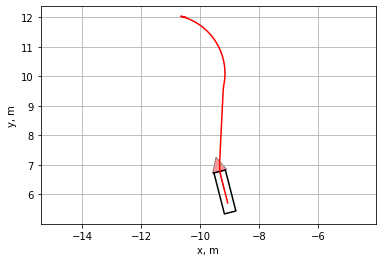

234


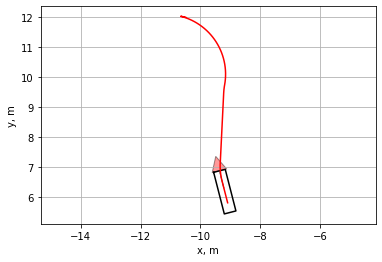

235


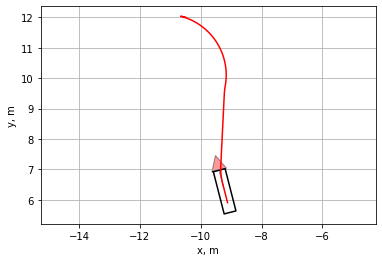

236


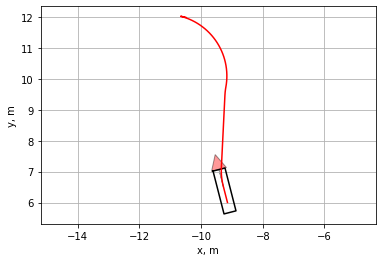

237


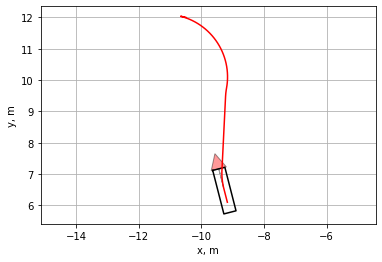

238


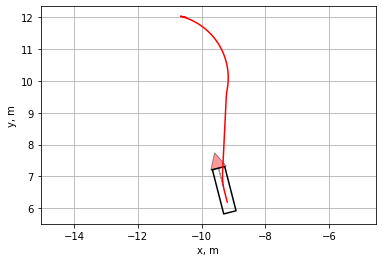

239


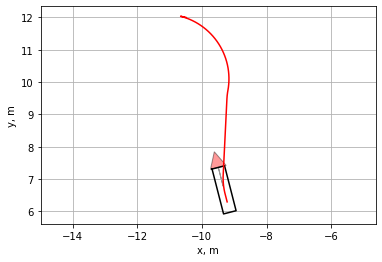

240


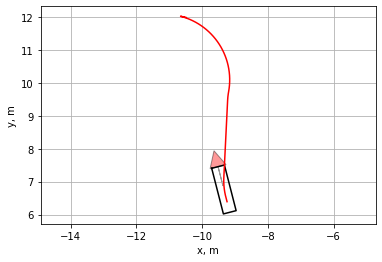

241


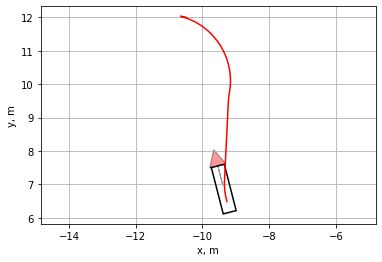

242


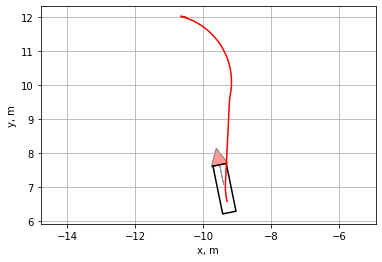

243


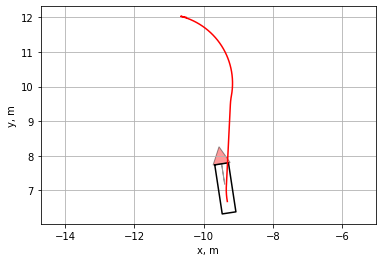

244


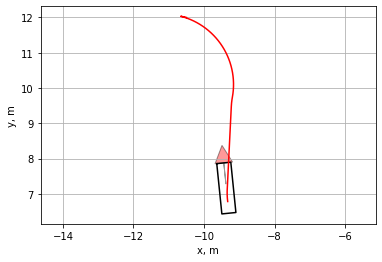

245


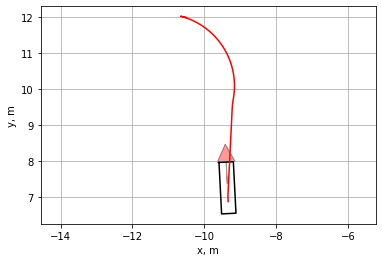

246


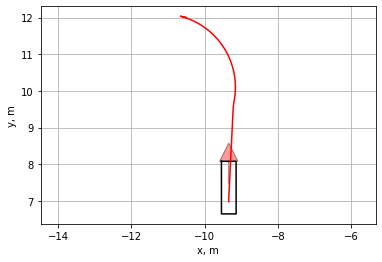

247


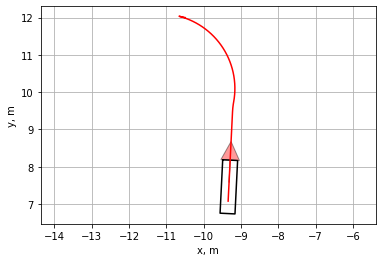

248


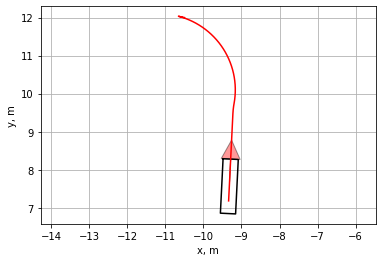

249


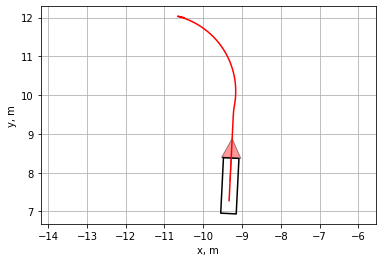

250


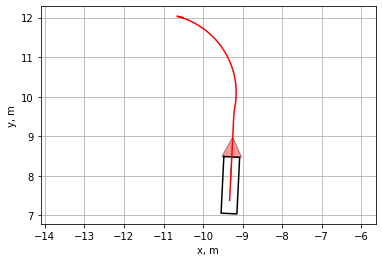

251


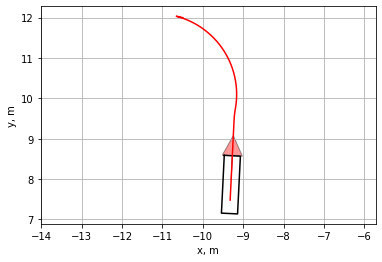

252


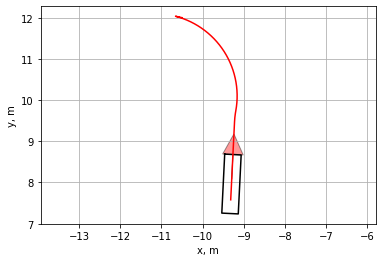

253


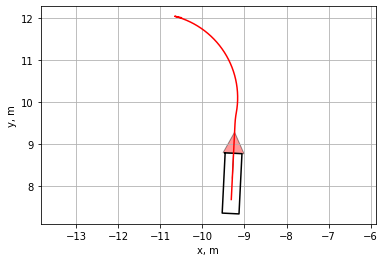

254


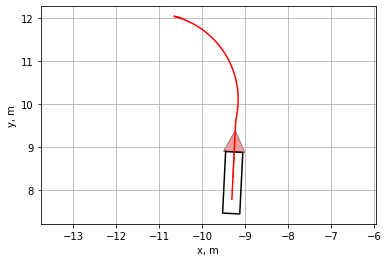

255


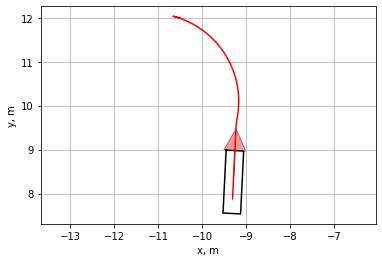

256


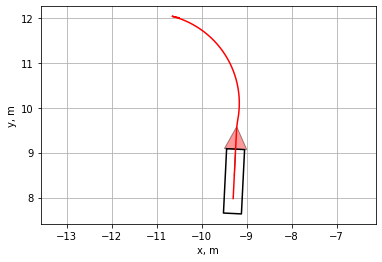

257


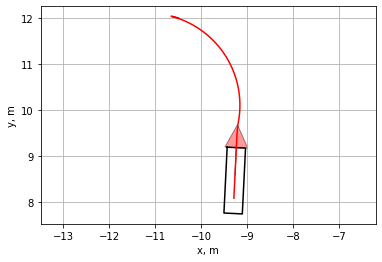

258


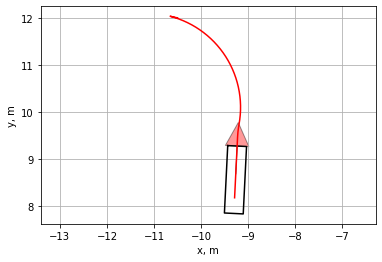

259


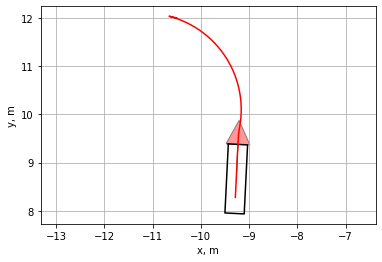

260


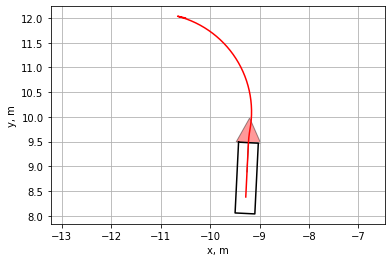

261


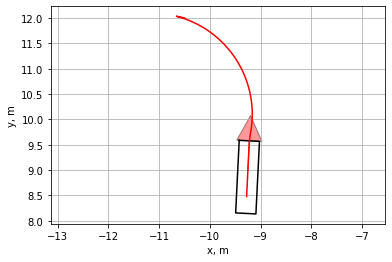

262


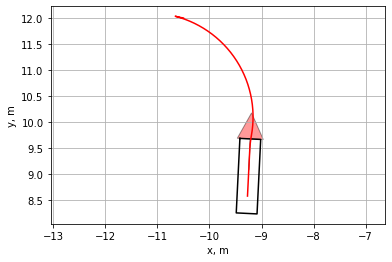

263


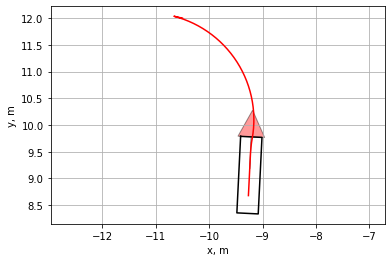

264


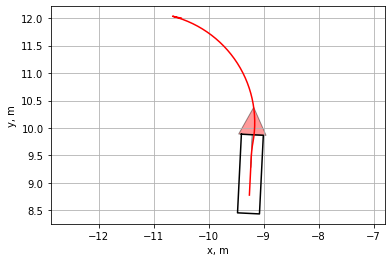

265


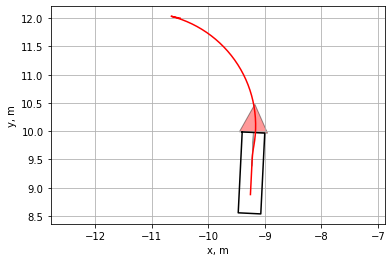

266


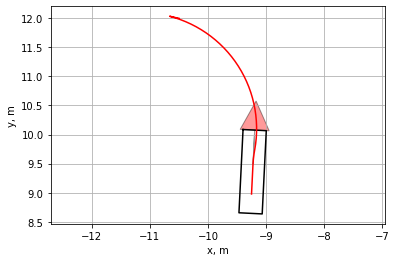

267


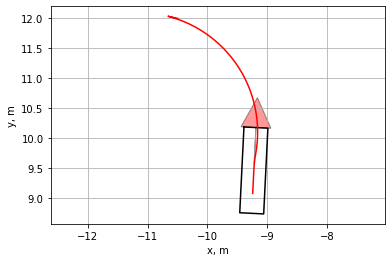

268


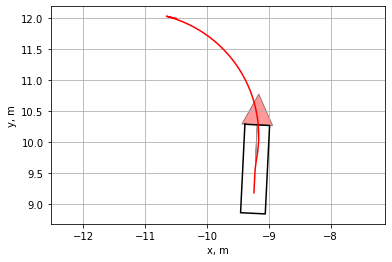

269


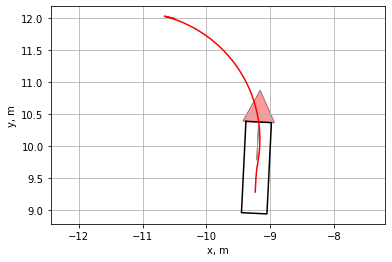

270


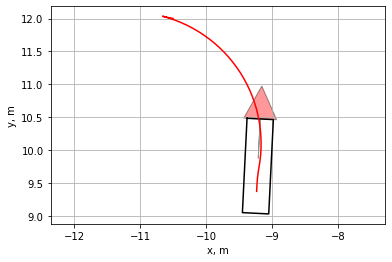

271


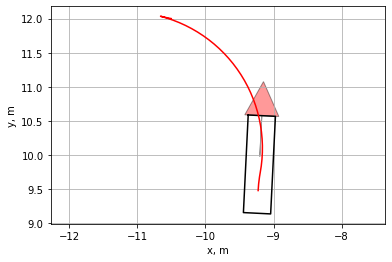

272


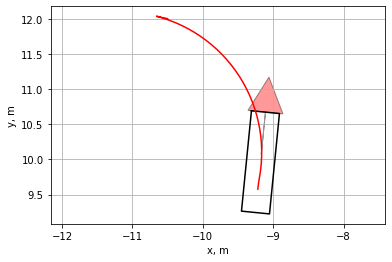

273


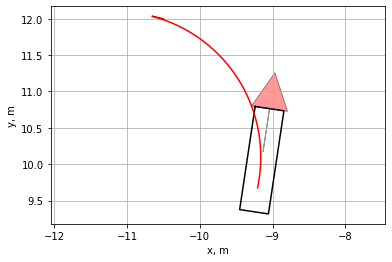

274


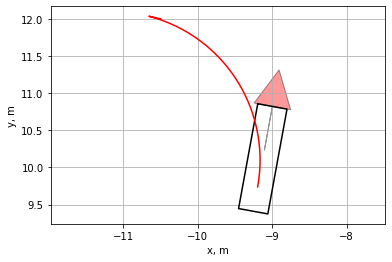

275


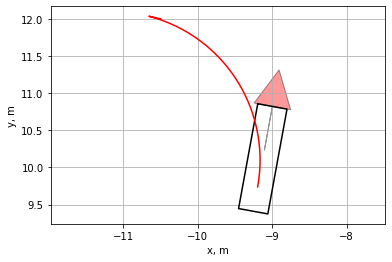

276


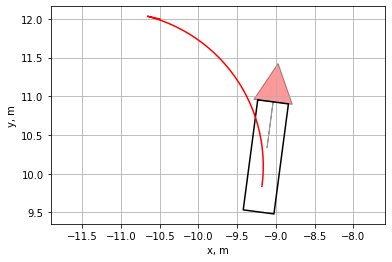

277


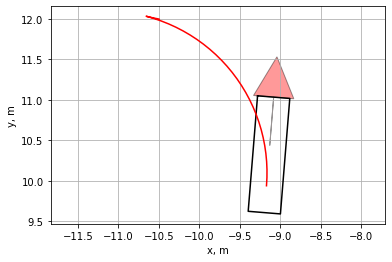

278


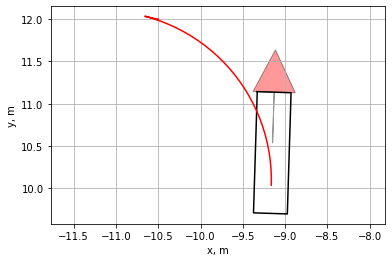

279


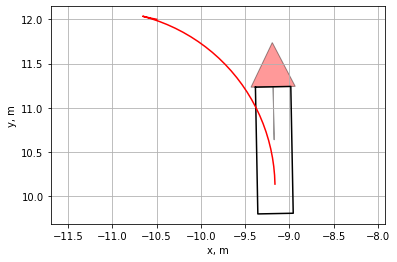

280


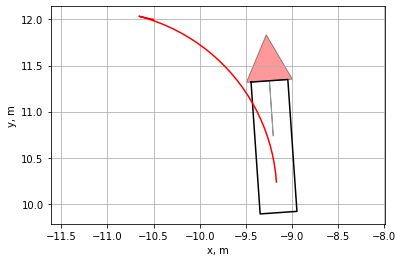

281


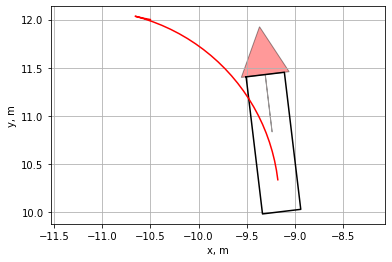

282


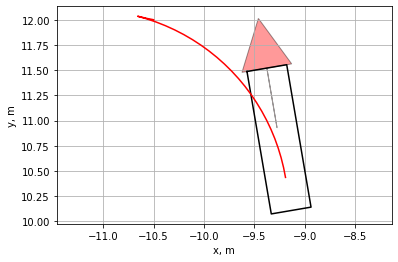

283


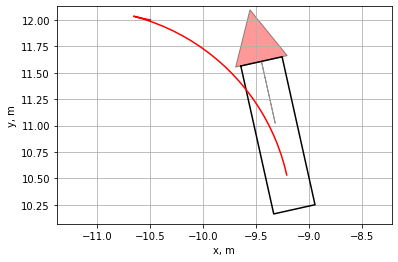

284


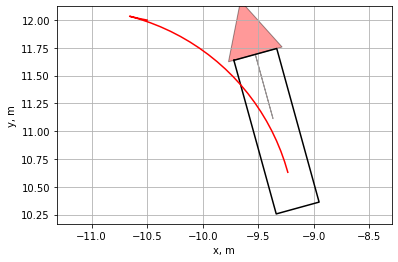

285


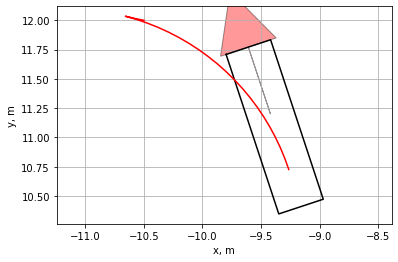

286


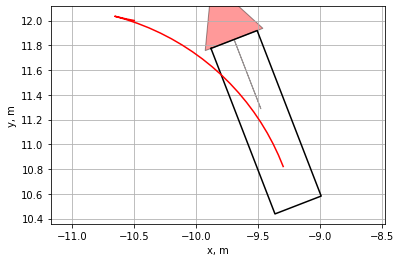

287


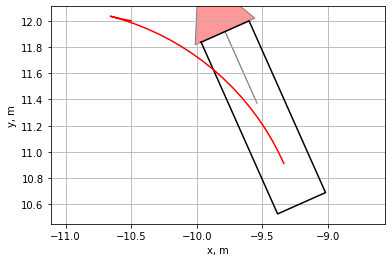

288


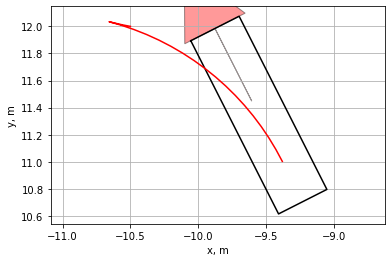

289


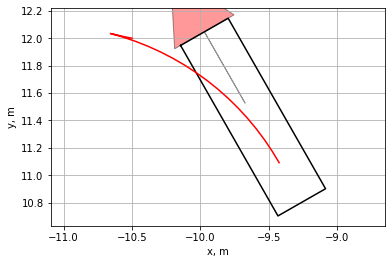

290


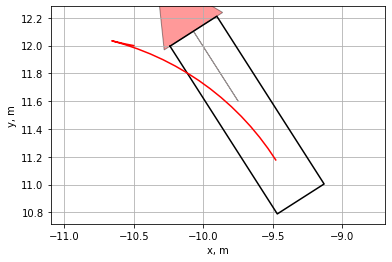

291


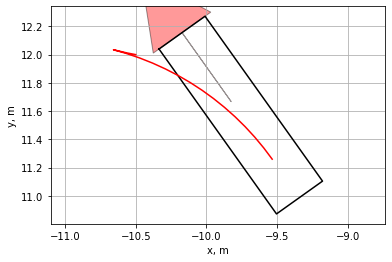

292


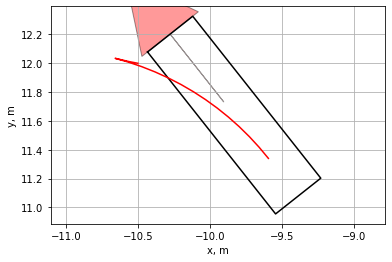

293


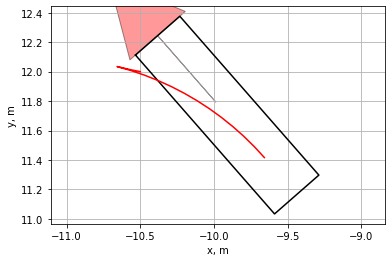

294


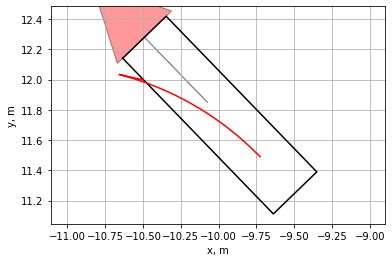

295


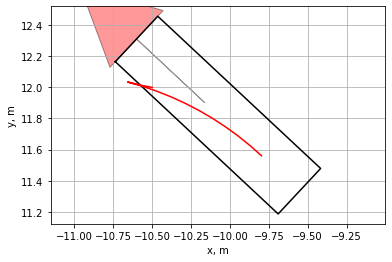

296


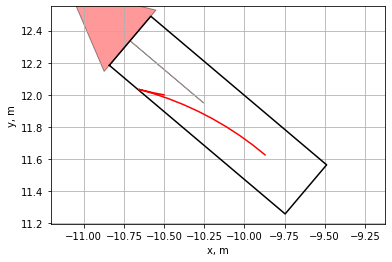

297


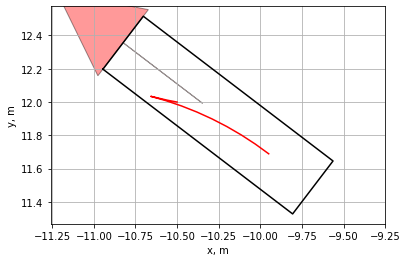

298


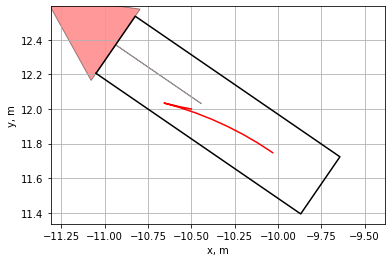

299


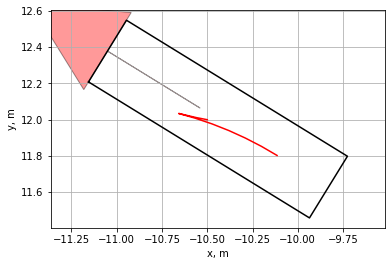

300


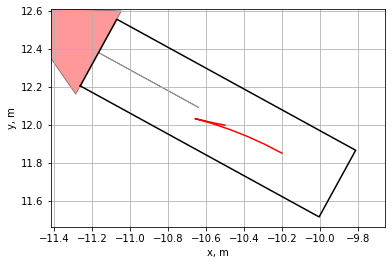

301


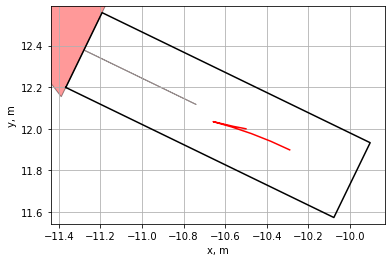

302


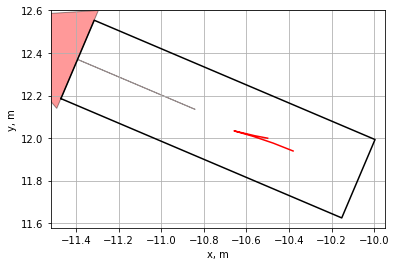

303


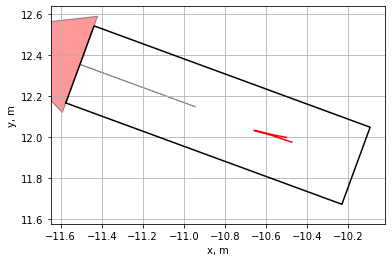

304


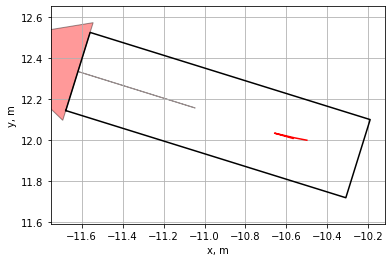

305


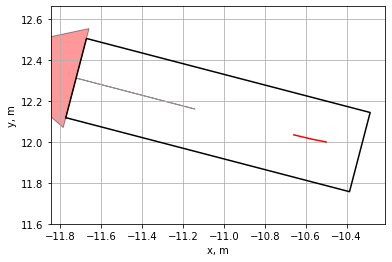

306


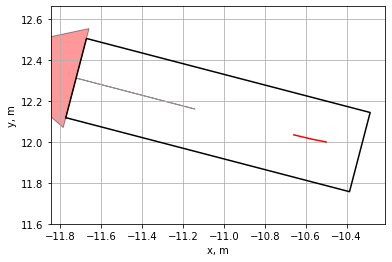

307


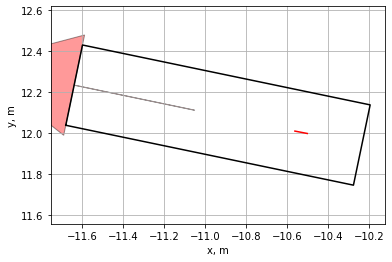

Robot0 finished way


SyntaxError: 'break' outside loop (3973130716.py, line 37)

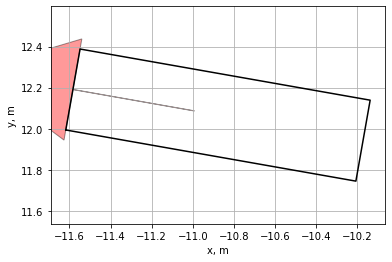

In [7]:
print("start")
fig = plt.figure(figsize = (10,10))
ax = plt.axes()

ii=0
border_size = 100

goal1 = [-10.5, 12, np.deg2rad(170.0)]
start1 = [0.0, -15, np.deg2rad(70.0)]
border_size = 100
robot1 = Robot(0, start1, goal1, border_size, obstacles_full, 15)

start2 = [-10, -10, np.deg2rad(45.0)]
goal2 =  [5, 10, np.deg2rad(100.0)]
robot2 = Robot(1, start2, goal2, border_size, obstacles_full, 7)

robot_list = [robot1, robot2]
robor_env = Robot_envieroment(robot_list, obstacles_full, MIN_R)

while(1):        
    plt.cla()
    robor_env.show(ax)

    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("x, m")
    plt.ylabel("y, m")
    plt.draw()  
    
    stop = robor_env.move()
    if(stop):
        break
        
    ii +=1
    print(ii)
    plt.pause(0.001) 




In [6]:
a = set([1,2,3])
b = set([3,4,2,5])
diff = a.intersection(b)
print(diff)
diff.union(b)

{2, 3}


{2, 3, 4, 5}